In [150]:
import pandas as pd
import googlemaps
import config
import mysql.connector
import time
import config
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from datetime import datetime
import calendar
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn import svm, tree
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.dummy import DummyClassifier
from sklearn import svm
from sklearn.tree import export_graphviz
import pydotplus
from IPython.display import Image
from sklearn.externals.six import StringIO
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import itertools
from imblearn.over_sampling import SMOTE

In [125]:
data = pd.read_csv('citibike.csv')
data = data.drop('Unnamed: 0', axis=1)

In [3]:
data.head()

,tripduration,start_station_name,end_station_name,gender,distance,age,weekday,time_of_day,usertype
0,311,Newark Ave,Montgomery St,Male,919,30,Monday,Night,Subscriber
1,282,Marin Light Rail,Grove St PATH,Male,684,30,Monday,Night,Subscriber
2,431,Morris Canal,Warren St,Female,1147,42,Thursday,Afternoon,Subscriber
3,207,Hamilton Park,Grove St PATH,Male,1099,31,Tuesday,Morning,Subscriber
4,330,Grove St PATH,Marin Light Rail,Female,684,34,Tuesday,Night,Subscriber


## EDA

In [4]:
summary_data = pd.read_csv('citibikedataV2.csv')
summary_data['usertype'].value_counts()

Subscriber    16114
Customer       1886
Name: usertype, dtype: int64

### Subscribers vs customers 

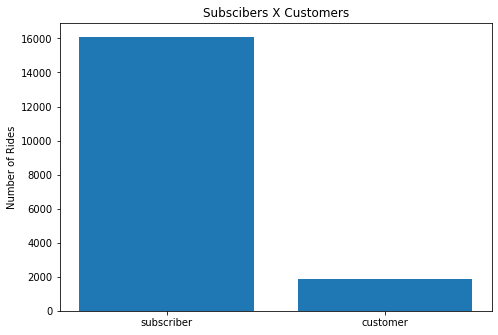

In [5]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
business_type = ['subscriber', 'customer']
users = [16114,1886]
ax.bar(business_type, users)
plt.ylabel('Number of Rides')
plt.title('Subscibers X Customers')
plt.show()

Text(0.5, 1.0, 'Rider Age Distribution')

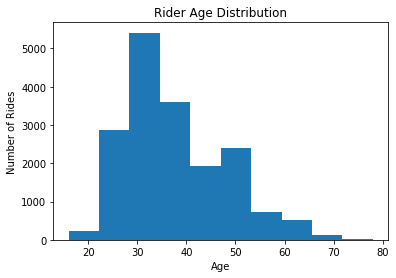

In [6]:
plt.hist(data['age'])
plt.xlabel('Age')
plt.ylabel('Number of Rides')
plt.title('Rider Age Distribution')

Text(0.5, 0, 'Arrival Station')

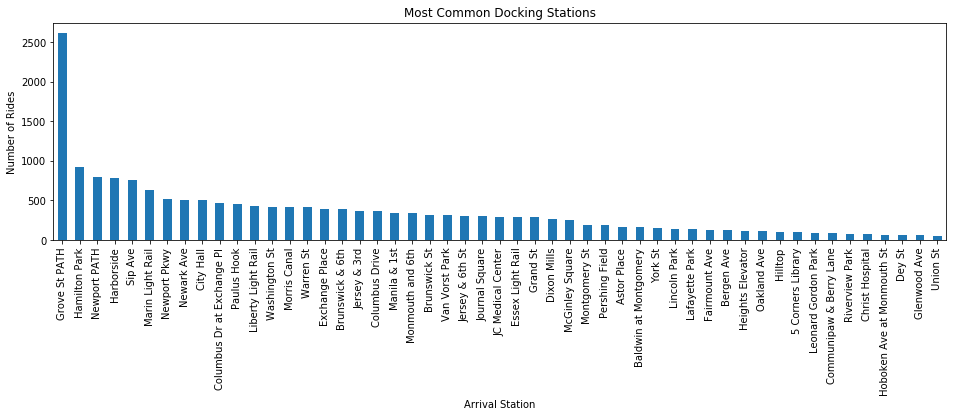

In [7]:
fig2 = data['end_station_name'].value_counts().plot(kind='bar', figsize=(16,4), title='Most Common Docking Stations')
plt.ylabel('Number of Rides')
plt.xlabel('Arrival Station')

Text(0.5, 0, 'Day')

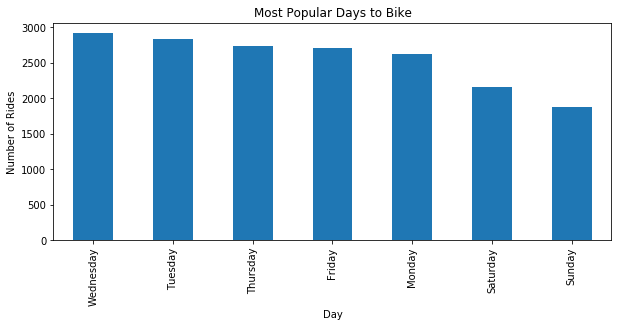

In [8]:
fig2 = data['weekday'].value_counts().plot(kind='bar', figsize=(10,4), title='Most Popular Days to Bike')
plt.ylabel('Number of Rides')
plt.xlabel('Day')

Text(0.5, 0, 'Departure Station')

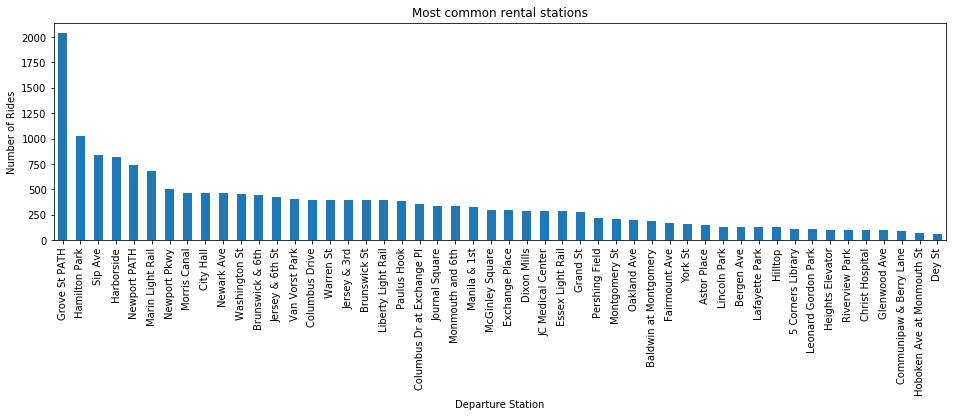

In [9]:
fig1 = data['start_station_name'].value_counts().plot(kind='bar', figsize=(16,4), title='Most common rental stations')
plt.ylabel('Number of Rides')
plt.xlabel('Departure Station')

Text(0.5, 0, 'Time of Day')

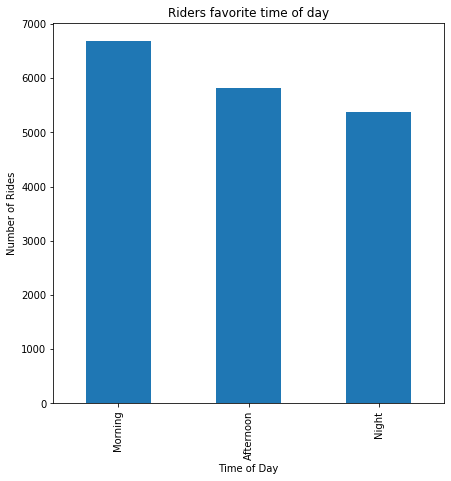

In [10]:
fig3 = data['time_of_day'].value_counts().plot(kind='bar', figsize=(7,7), title='Riders favorite time of day')
plt.ylabel('Number of Rides')
plt.xlabel('Time of Day')

# Feature Engineering

## Creating time categorization 

In [387]:
starttime = list(model_data['starttime'])
stoptime = list(model_data['stoptime'])

model_data['starttime'] = model_data['starttime'].str.split('.').str[0]
model_data['stoptime'] = model_data['stoptime'].str.split('.').str[0]

days_of_week = []

for n in range(len(starttime)):
    my_string = starttime[n]
    my_date = datetime.strptime(my_string, "%Y-%m-%d %H:%M:%S")
    weekday = calendar.day_name[my_date.weekday()]
    days_of_week.append(weekday)
    
days_of_week

['2019-08-26 19:55:14',
 '2019-09-16 19:15:11',
 '2019-07-18 13:03:46',
 '2018-12-25 11:50:28',
 '2019-08-13 18:33:33',
 '2019-10-03 18:25:41',
 '2019-07-24 08:27:46',
 '2019-09-15 19:27:04',
 '2019-09-30 17:55:39',
 '2019-09-30 08:36:09',
 '2019-08-23 17:13:36',
 '2019-10-22 07:34:25',
 '2019-09-20 16:35:57',
 '2019-08-29 14:32:35',
 '2018-12-18 23:24:21',
 '2019-07-03 16:24:37',
 '2019-06-27 13:45:12',
 '2019-03-19 12:16:03',
 '2019-08-10 18:52:53',
 '2019-09-07 08:45:07',
 '2019-04-07 14:18:05',
 '2019-10-22 08:23:29',
 '2019-08-19 09:23:15',
 '2019-09-17 09:22:28',
 '2019-07-05 02:44:52',
 '2019-10-29 11:37:57',
 '2019-02-19 08:10:32',
 '2019-09-19 06:34:05',
 '2019-08-28 14:40:23',
 '2019-06-25 18:20:11',
 '2019-07-19 06:16:19',
 '2019-09-12 11:27:44',
 '2019-05-21 17:42:03',
 '2019-07-22 17:42:24',
 '2019-09-11 17:55:10',
 '2019-03-05 09:16:07',
 '2019-07-07 21:51:31',
 '2019-07-30 19:00:02',
 '2019-05-26 11:40:02',
 '2019-07-12 14:51:00',
 '2019-01-09 07:40:59',
 '2019-07-18 18:

## Calculate distance between bike stations using Google distance matrix API

In [78]:
jan = pd.read_csv('Jan_citibike_tripdata.csv')
feb = pd.read_csv('Feb_citibike_tripdata.csv')
mar = pd.read_csv('Mar_citibike_tripdata.csv')
apr = pd.read_csv('Apr_citibike_tripdata.csv')
may = pd.read_csv('May_citibike_tripdata.csv')
jun = pd.read_csv('Jun_citibike_tripdata.csv')
jul = pd.read_csv('Jul_citibike_tripdata.csv')
aug = pd.read_csv('Aug_citibike_tripdata.csv')
sep = pd.read_csv('Sep_citibike_tripdata.csv')
october = pd.read_csv('Oct_citibike_tripdata.csv')
nov = pd.read_csv('Nov_citibike_tripdata.csv')

In [79]:
full_data_set = pd.concat([jan, feb, mar, apr, may, jun, jul, aug, sep, october, nov])

In [80]:
redone_datasample = full_data_set.sample(18000, random_state = 10)

In [81]:
redone_datasample.columns = ['tripduration', 'starttime', 'stoptime', 'start_station_id',
       'start_station_name', 'start_station_lat',
       'start_station_lon', 'end_station_id', 'end_station_name',
       'end_station_lat', 'end_station_lon', 'bikeid', 'usertype',
       'birth_year', 'gender']

In [82]:
start_latitude = list(redone_datasample['start_station_lat'])
start_longitude = list(redone_datasample['start_station_lon'])
end_latitude = list(redone_datasample['end_station_lat'])
end_longitude = list(redone_datasample['end_station_lon'])

# google maps api key

# Requires API key 
# gmaps = googlemaps.Client(key=api_key)

In [255]:
travel_distance = []
parsed_distance = []
backup_parsed = []

def distance_calculator():
    #Get the distance for each thing
    for n in range(len(redone_datasample)):
        origins = (start_latitude[n], start_longitude[n])
        destinations = (end_latitude[n], end_longitude[n])
        matrix = gmaps.distance_matrix(origins, destinations, mode="bicycling")
        travel_distance.append(matrix)
        print(f"row {n} distance has been calculated!")
        time.sleep(.1)
        #parse the data
        parsed_distance.append(travel_distance[n]['rows'][0]['elements'][0]['distance']['value'])
        #back it up
        backup_parsed.append(travel_distance[n]['rows'][0]['elements'][0]['distance']['value'])
        print(f"row {n} has been parsed!")
    return parsed_distance

In [256]:
distance_calculator()

row 0 distance has been calculated!
row 0 has been parsed!
row 1 distance has been calculated!
row 1 has been parsed!
row 2 distance has been calculated!
row 2 has been parsed!
row 3 distance has been calculated!
row 3 has been parsed!
row 4 distance has been calculated!
row 4 has been parsed!
row 5 distance has been calculated!
row 5 has been parsed!
row 6 distance has been calculated!
row 6 has been parsed!
row 7 distance has been calculated!
row 7 has been parsed!
row 8 distance has been calculated!
row 8 has been parsed!
row 9 distance has been calculated!
row 9 has been parsed!
row 10 distance has been calculated!
row 10 has been parsed!
row 11 distance has been calculated!
row 11 has been parsed!
row 12 distance has been calculated!
row 12 has been parsed!
row 13 distance has been calculated!
row 13 has been parsed!
row 14 distance has been calculated!
row 14 has been parsed!
row 15 distance has been calculated!
row 15 has been parsed!
row 16 distance has been calculated!
row 16 

row 134 distance has been calculated!
row 134 has been parsed!
row 135 distance has been calculated!
row 135 has been parsed!
row 136 distance has been calculated!
row 136 has been parsed!
row 137 distance has been calculated!
row 137 has been parsed!
row 138 distance has been calculated!
row 138 has been parsed!
row 139 distance has been calculated!
row 139 has been parsed!
row 140 distance has been calculated!
row 140 has been parsed!
row 141 distance has been calculated!
row 141 has been parsed!
row 142 distance has been calculated!
row 142 has been parsed!
row 143 distance has been calculated!
row 143 has been parsed!
row 144 distance has been calculated!
row 144 has been parsed!
row 145 distance has been calculated!
row 145 has been parsed!
row 146 distance has been calculated!
row 146 has been parsed!
row 147 distance has been calculated!
row 147 has been parsed!
row 148 distance has been calculated!
row 148 has been parsed!
row 149 distance has been calculated!
row 149 has been 

row 264 has been parsed!
row 265 distance has been calculated!
row 265 has been parsed!
row 266 distance has been calculated!
row 266 has been parsed!
row 267 distance has been calculated!
row 267 has been parsed!
row 268 distance has been calculated!
row 268 has been parsed!
row 269 distance has been calculated!
row 269 has been parsed!
row 270 distance has been calculated!
row 270 has been parsed!
row 271 distance has been calculated!
row 271 has been parsed!
row 272 distance has been calculated!
row 272 has been parsed!
row 273 distance has been calculated!
row 273 has been parsed!
row 274 distance has been calculated!
row 274 has been parsed!
row 275 distance has been calculated!
row 275 has been parsed!
row 276 distance has been calculated!
row 276 has been parsed!
row 277 distance has been calculated!
row 277 has been parsed!
row 278 distance has been calculated!
row 278 has been parsed!
row 279 distance has been calculated!
row 279 has been parsed!
row 280 distance has been calc

row 396 distance has been calculated!
row 396 has been parsed!
row 397 distance has been calculated!
row 397 has been parsed!
row 398 distance has been calculated!
row 398 has been parsed!
row 399 distance has been calculated!
row 399 has been parsed!
row 400 distance has been calculated!
row 400 has been parsed!
row 401 distance has been calculated!
row 401 has been parsed!
row 402 distance has been calculated!
row 402 has been parsed!
row 403 distance has been calculated!
row 403 has been parsed!
row 404 distance has been calculated!
row 404 has been parsed!
row 405 distance has been calculated!
row 405 has been parsed!
row 406 distance has been calculated!
row 406 has been parsed!
row 407 distance has been calculated!
row 407 has been parsed!
row 408 distance has been calculated!
row 408 has been parsed!
row 409 distance has been calculated!
row 409 has been parsed!
row 410 distance has been calculated!
row 410 has been parsed!
row 411 distance has been calculated!
row 411 has been 

row 527 has been parsed!
row 528 distance has been calculated!
row 528 has been parsed!
row 529 distance has been calculated!
row 529 has been parsed!
row 530 distance has been calculated!
row 530 has been parsed!
row 531 distance has been calculated!
row 531 has been parsed!
row 532 distance has been calculated!
row 532 has been parsed!
row 533 distance has been calculated!
row 533 has been parsed!
row 534 distance has been calculated!
row 534 has been parsed!
row 535 distance has been calculated!
row 535 has been parsed!
row 536 distance has been calculated!
row 536 has been parsed!
row 537 distance has been calculated!
row 537 has been parsed!
row 538 distance has been calculated!
row 538 has been parsed!
row 539 distance has been calculated!
row 539 has been parsed!
row 540 distance has been calculated!
row 540 has been parsed!
row 541 distance has been calculated!
row 541 has been parsed!
row 542 distance has been calculated!
row 542 has been parsed!
row 543 distance has been calc

row 658 distance has been calculated!
row 658 has been parsed!
row 659 distance has been calculated!
row 659 has been parsed!
row 660 distance has been calculated!
row 660 has been parsed!
row 661 distance has been calculated!
row 661 has been parsed!
row 662 distance has been calculated!
row 662 has been parsed!
row 663 distance has been calculated!
row 663 has been parsed!
row 664 distance has been calculated!
row 664 has been parsed!
row 665 distance has been calculated!
row 665 has been parsed!
row 666 distance has been calculated!
row 666 has been parsed!
row 667 distance has been calculated!
row 667 has been parsed!
row 668 distance has been calculated!
row 668 has been parsed!
row 669 distance has been calculated!
row 669 has been parsed!
row 670 distance has been calculated!
row 670 has been parsed!
row 671 distance has been calculated!
row 671 has been parsed!
row 672 distance has been calculated!
row 672 has been parsed!
row 673 distance has been calculated!
row 673 has been 

row 789 has been parsed!
row 790 distance has been calculated!
row 790 has been parsed!
row 791 distance has been calculated!
row 791 has been parsed!
row 792 distance has been calculated!
row 792 has been parsed!
row 793 distance has been calculated!
row 793 has been parsed!
row 794 distance has been calculated!
row 794 has been parsed!
row 795 distance has been calculated!
row 795 has been parsed!
row 796 distance has been calculated!
row 796 has been parsed!
row 797 distance has been calculated!
row 797 has been parsed!
row 798 distance has been calculated!
row 798 has been parsed!
row 799 distance has been calculated!
row 799 has been parsed!
row 800 distance has been calculated!
row 800 has been parsed!
row 801 distance has been calculated!
row 801 has been parsed!
row 802 distance has been calculated!
row 802 has been parsed!
row 803 distance has been calculated!
row 803 has been parsed!
row 804 distance has been calculated!
row 804 has been parsed!
row 805 distance has been calc

row 920 distance has been calculated!
row 920 has been parsed!
row 921 distance has been calculated!
row 921 has been parsed!
row 922 distance has been calculated!
row 922 has been parsed!
row 923 distance has been calculated!
row 923 has been parsed!
row 924 distance has been calculated!
row 924 has been parsed!
row 925 distance has been calculated!
row 925 has been parsed!
row 926 distance has been calculated!
row 926 has been parsed!
row 927 distance has been calculated!
row 927 has been parsed!
row 928 distance has been calculated!
row 928 has been parsed!
row 929 distance has been calculated!
row 929 has been parsed!
row 930 distance has been calculated!
row 930 has been parsed!
row 931 distance has been calculated!
row 931 has been parsed!
row 932 distance has been calculated!
row 932 has been parsed!
row 933 distance has been calculated!
row 933 has been parsed!
row 934 distance has been calculated!
row 934 has been parsed!
row 935 distance has been calculated!
row 935 has been 

row 1048 has been parsed!
row 1049 distance has been calculated!
row 1049 has been parsed!
row 1050 distance has been calculated!
row 1050 has been parsed!
row 1051 distance has been calculated!
row 1051 has been parsed!
row 1052 distance has been calculated!
row 1052 has been parsed!
row 1053 distance has been calculated!
row 1053 has been parsed!
row 1054 distance has been calculated!
row 1054 has been parsed!
row 1055 distance has been calculated!
row 1055 has been parsed!
row 1056 distance has been calculated!
row 1056 has been parsed!
row 1057 distance has been calculated!
row 1057 has been parsed!
row 1058 distance has been calculated!
row 1058 has been parsed!
row 1059 distance has been calculated!
row 1059 has been parsed!
row 1060 distance has been calculated!
row 1060 has been parsed!
row 1061 distance has been calculated!
row 1061 has been parsed!
row 1062 distance has been calculated!
row 1062 has been parsed!
row 1063 distance has been calculated!
row 1063 has been parsed!

row 1175 has been parsed!
row 1176 distance has been calculated!
row 1176 has been parsed!
row 1177 distance has been calculated!
row 1177 has been parsed!
row 1178 distance has been calculated!
row 1178 has been parsed!
row 1179 distance has been calculated!
row 1179 has been parsed!
row 1180 distance has been calculated!
row 1180 has been parsed!
row 1181 distance has been calculated!
row 1181 has been parsed!
row 1182 distance has been calculated!
row 1182 has been parsed!
row 1183 distance has been calculated!
row 1183 has been parsed!
row 1184 distance has been calculated!
row 1184 has been parsed!
row 1185 distance has been calculated!
row 1185 has been parsed!
row 1186 distance has been calculated!
row 1186 has been parsed!
row 1187 distance has been calculated!
row 1187 has been parsed!
row 1188 distance has been calculated!
row 1188 has been parsed!
row 1189 distance has been calculated!
row 1189 has been parsed!
row 1190 distance has been calculated!
row 1190 has been parsed!

row 1302 distance has been calculated!
row 1302 has been parsed!
row 1303 distance has been calculated!
row 1303 has been parsed!
row 1304 distance has been calculated!
row 1304 has been parsed!
row 1305 distance has been calculated!
row 1305 has been parsed!
row 1306 distance has been calculated!
row 1306 has been parsed!
row 1307 distance has been calculated!
row 1307 has been parsed!
row 1308 distance has been calculated!
row 1308 has been parsed!
row 1309 distance has been calculated!
row 1309 has been parsed!
row 1310 distance has been calculated!
row 1310 has been parsed!
row 1311 distance has been calculated!
row 1311 has been parsed!
row 1312 distance has been calculated!
row 1312 has been parsed!
row 1313 distance has been calculated!
row 1313 has been parsed!
row 1314 distance has been calculated!
row 1314 has been parsed!
row 1315 distance has been calculated!
row 1315 has been parsed!
row 1316 distance has been calculated!
row 1316 has been parsed!
row 1317 distance has bee

row 1429 has been parsed!
row 1430 distance has been calculated!
row 1430 has been parsed!
row 1431 distance has been calculated!
row 1431 has been parsed!
row 1432 distance has been calculated!
row 1432 has been parsed!
row 1433 distance has been calculated!
row 1433 has been parsed!
row 1434 distance has been calculated!
row 1434 has been parsed!
row 1435 distance has been calculated!
row 1435 has been parsed!
row 1436 distance has been calculated!
row 1436 has been parsed!
row 1437 distance has been calculated!
row 1437 has been parsed!
row 1438 distance has been calculated!
row 1438 has been parsed!
row 1439 distance has been calculated!
row 1439 has been parsed!
row 1440 distance has been calculated!
row 1440 has been parsed!
row 1441 distance has been calculated!
row 1441 has been parsed!
row 1442 distance has been calculated!
row 1442 has been parsed!
row 1443 distance has been calculated!
row 1443 has been parsed!
row 1444 distance has been calculated!
row 1444 has been parsed!

row 1557 distance has been calculated!
row 1557 has been parsed!
row 1558 distance has been calculated!
row 1558 has been parsed!
row 1559 distance has been calculated!
row 1559 has been parsed!
row 1560 distance has been calculated!
row 1560 has been parsed!
row 1561 distance has been calculated!
row 1561 has been parsed!
row 1562 distance has been calculated!
row 1562 has been parsed!
row 1563 distance has been calculated!
row 1563 has been parsed!
row 1564 distance has been calculated!
row 1564 has been parsed!
row 1565 distance has been calculated!
row 1565 has been parsed!
row 1566 distance has been calculated!
row 1566 has been parsed!
row 1567 distance has been calculated!
row 1567 has been parsed!
row 1568 distance has been calculated!
row 1568 has been parsed!
row 1569 distance has been calculated!
row 1569 has been parsed!
row 1570 distance has been calculated!
row 1570 has been parsed!
row 1571 distance has been calculated!
row 1571 has been parsed!
row 1572 distance has bee

row 1684 distance has been calculated!
row 1684 has been parsed!
row 1685 distance has been calculated!
row 1685 has been parsed!
row 1686 distance has been calculated!
row 1686 has been parsed!
row 1687 distance has been calculated!
row 1687 has been parsed!
row 1688 distance has been calculated!
row 1688 has been parsed!
row 1689 distance has been calculated!
row 1689 has been parsed!
row 1690 distance has been calculated!
row 1690 has been parsed!
row 1691 distance has been calculated!
row 1691 has been parsed!
row 1692 distance has been calculated!
row 1692 has been parsed!
row 1693 distance has been calculated!
row 1693 has been parsed!
row 1694 distance has been calculated!
row 1694 has been parsed!
row 1695 distance has been calculated!
row 1695 has been parsed!
row 1696 distance has been calculated!
row 1696 has been parsed!
row 1697 distance has been calculated!
row 1697 has been parsed!
row 1698 distance has been calculated!
row 1698 has been parsed!
row 1699 distance has bee

row 1811 has been parsed!
row 1812 distance has been calculated!
row 1812 has been parsed!
row 1813 distance has been calculated!
row 1813 has been parsed!
row 1814 distance has been calculated!
row 1814 has been parsed!
row 1815 distance has been calculated!
row 1815 has been parsed!
row 1816 distance has been calculated!
row 1816 has been parsed!
row 1817 distance has been calculated!
row 1817 has been parsed!
row 1818 distance has been calculated!
row 1818 has been parsed!
row 1819 distance has been calculated!
row 1819 has been parsed!
row 1820 distance has been calculated!
row 1820 has been parsed!
row 1821 distance has been calculated!
row 1821 has been parsed!
row 1822 distance has been calculated!
row 1822 has been parsed!
row 1823 distance has been calculated!
row 1823 has been parsed!
row 1824 distance has been calculated!
row 1824 has been parsed!
row 1825 distance has been calculated!
row 1825 has been parsed!
row 1826 distance has been calculated!
row 1826 has been parsed!

row 1938 distance has been calculated!
row 1938 has been parsed!
row 1939 distance has been calculated!
row 1939 has been parsed!
row 1940 distance has been calculated!
row 1940 has been parsed!
row 1941 distance has been calculated!
row 1941 has been parsed!
row 1942 distance has been calculated!
row 1942 has been parsed!
row 1943 distance has been calculated!
row 1943 has been parsed!
row 1944 distance has been calculated!
row 1944 has been parsed!
row 1945 distance has been calculated!
row 1945 has been parsed!
row 1946 distance has been calculated!
row 1946 has been parsed!
row 1947 distance has been calculated!
row 1947 has been parsed!
row 1948 distance has been calculated!
row 1948 has been parsed!
row 1949 distance has been calculated!
row 1949 has been parsed!
row 1950 distance has been calculated!
row 1950 has been parsed!
row 1951 distance has been calculated!
row 1951 has been parsed!
row 1952 distance has been calculated!
row 1952 has been parsed!
row 1953 distance has bee

row 2065 distance has been calculated!
row 2065 has been parsed!
row 2066 distance has been calculated!
row 2066 has been parsed!
row 2067 distance has been calculated!
row 2067 has been parsed!
row 2068 distance has been calculated!
row 2068 has been parsed!
row 2069 distance has been calculated!
row 2069 has been parsed!
row 2070 distance has been calculated!
row 2070 has been parsed!
row 2071 distance has been calculated!
row 2071 has been parsed!
row 2072 distance has been calculated!
row 2072 has been parsed!
row 2073 distance has been calculated!
row 2073 has been parsed!
row 2074 distance has been calculated!
row 2074 has been parsed!
row 2075 distance has been calculated!
row 2075 has been parsed!
row 2076 distance has been calculated!
row 2076 has been parsed!
row 2077 distance has been calculated!
row 2077 has been parsed!
row 2078 distance has been calculated!
row 2078 has been parsed!
row 2079 distance has been calculated!
row 2079 has been parsed!
row 2080 distance has bee

row 2192 distance has been calculated!
row 2192 has been parsed!
row 2193 distance has been calculated!
row 2193 has been parsed!
row 2194 distance has been calculated!
row 2194 has been parsed!
row 2195 distance has been calculated!
row 2195 has been parsed!
row 2196 distance has been calculated!
row 2196 has been parsed!
row 2197 distance has been calculated!
row 2197 has been parsed!
row 2198 distance has been calculated!
row 2198 has been parsed!
row 2199 distance has been calculated!
row 2199 has been parsed!
row 2200 distance has been calculated!
row 2200 has been parsed!
row 2201 distance has been calculated!
row 2201 has been parsed!
row 2202 distance has been calculated!
row 2202 has been parsed!
row 2203 distance has been calculated!
row 2203 has been parsed!
row 2204 distance has been calculated!
row 2204 has been parsed!
row 2205 distance has been calculated!
row 2205 has been parsed!
row 2206 distance has been calculated!
row 2206 has been parsed!
row 2207 distance has bee

row 2318 has been parsed!
row 2319 distance has been calculated!
row 2319 has been parsed!
row 2320 distance has been calculated!
row 2320 has been parsed!
row 2321 distance has been calculated!
row 2321 has been parsed!
row 2322 distance has been calculated!
row 2322 has been parsed!
row 2323 distance has been calculated!
row 2323 has been parsed!
row 2324 distance has been calculated!
row 2324 has been parsed!
row 2325 distance has been calculated!
row 2325 has been parsed!
row 2326 distance has been calculated!
row 2326 has been parsed!
row 2327 distance has been calculated!
row 2327 has been parsed!
row 2328 distance has been calculated!
row 2328 has been parsed!
row 2329 distance has been calculated!
row 2329 has been parsed!
row 2330 distance has been calculated!
row 2330 has been parsed!
row 2331 distance has been calculated!
row 2331 has been parsed!
row 2332 distance has been calculated!
row 2332 has been parsed!
row 2333 distance has been calculated!
row 2333 has been parsed!

row 2445 distance has been calculated!
row 2445 has been parsed!
row 2446 distance has been calculated!
row 2446 has been parsed!
row 2447 distance has been calculated!
row 2447 has been parsed!
row 2448 distance has been calculated!
row 2448 has been parsed!
row 2449 distance has been calculated!
row 2449 has been parsed!
row 2450 distance has been calculated!
row 2450 has been parsed!
row 2451 distance has been calculated!
row 2451 has been parsed!
row 2452 distance has been calculated!
row 2452 has been parsed!
row 2453 distance has been calculated!
row 2453 has been parsed!
row 2454 distance has been calculated!
row 2454 has been parsed!
row 2455 distance has been calculated!
row 2455 has been parsed!
row 2456 distance has been calculated!
row 2456 has been parsed!
row 2457 distance has been calculated!
row 2457 has been parsed!
row 2458 distance has been calculated!
row 2458 has been parsed!
row 2459 distance has been calculated!
row 2459 has been parsed!
row 2460 distance has bee

row 2571 has been parsed!
row 2572 distance has been calculated!
row 2572 has been parsed!
row 2573 distance has been calculated!
row 2573 has been parsed!
row 2574 distance has been calculated!
row 2574 has been parsed!
row 2575 distance has been calculated!
row 2575 has been parsed!
row 2576 distance has been calculated!
row 2576 has been parsed!
row 2577 distance has been calculated!
row 2577 has been parsed!
row 2578 distance has been calculated!
row 2578 has been parsed!
row 2579 distance has been calculated!
row 2579 has been parsed!
row 2580 distance has been calculated!
row 2580 has been parsed!
row 2581 distance has been calculated!
row 2581 has been parsed!
row 2582 distance has been calculated!
row 2582 has been parsed!
row 2583 distance has been calculated!
row 2583 has been parsed!
row 2584 distance has been calculated!
row 2584 has been parsed!
row 2585 distance has been calculated!
row 2585 has been parsed!
row 2586 distance has been calculated!
row 2586 has been parsed!

row 2699 distance has been calculated!
row 2699 has been parsed!
row 2700 distance has been calculated!
row 2700 has been parsed!
row 2701 distance has been calculated!
row 2701 has been parsed!
row 2702 distance has been calculated!
row 2702 has been parsed!
row 2703 distance has been calculated!
row 2703 has been parsed!
row 2704 distance has been calculated!
row 2704 has been parsed!
row 2705 distance has been calculated!
row 2705 has been parsed!
row 2706 distance has been calculated!
row 2706 has been parsed!
row 2707 distance has been calculated!
row 2707 has been parsed!
row 2708 distance has been calculated!
row 2708 has been parsed!
row 2709 distance has been calculated!
row 2709 has been parsed!
row 2710 distance has been calculated!
row 2710 has been parsed!
row 2711 distance has been calculated!
row 2711 has been parsed!
row 2712 distance has been calculated!
row 2712 has been parsed!
row 2713 distance has been calculated!
row 2713 has been parsed!
row 2714 distance has bee

row 2825 has been parsed!
row 2826 distance has been calculated!
row 2826 has been parsed!
row 2827 distance has been calculated!
row 2827 has been parsed!
row 2828 distance has been calculated!
row 2828 has been parsed!
row 2829 distance has been calculated!
row 2829 has been parsed!
row 2830 distance has been calculated!
row 2830 has been parsed!
row 2831 distance has been calculated!
row 2831 has been parsed!
row 2832 distance has been calculated!
row 2832 has been parsed!
row 2833 distance has been calculated!
row 2833 has been parsed!
row 2834 distance has been calculated!
row 2834 has been parsed!
row 2835 distance has been calculated!
row 2835 has been parsed!
row 2836 distance has been calculated!
row 2836 has been parsed!
row 2837 distance has been calculated!
row 2837 has been parsed!
row 2838 distance has been calculated!
row 2838 has been parsed!
row 2839 distance has been calculated!
row 2839 has been parsed!
row 2840 distance has been calculated!
row 2840 has been parsed!

row 2952 has been parsed!
row 2953 distance has been calculated!
row 2953 has been parsed!
row 2954 distance has been calculated!
row 2954 has been parsed!
row 2955 distance has been calculated!
row 2955 has been parsed!
row 2956 distance has been calculated!
row 2956 has been parsed!
row 2957 distance has been calculated!
row 2957 has been parsed!
row 2958 distance has been calculated!
row 2958 has been parsed!
row 2959 distance has been calculated!
row 2959 has been parsed!
row 2960 distance has been calculated!
row 2960 has been parsed!
row 2961 distance has been calculated!
row 2961 has been parsed!
row 2962 distance has been calculated!
row 2962 has been parsed!
row 2963 distance has been calculated!
row 2963 has been parsed!
row 2964 distance has been calculated!
row 2964 has been parsed!
row 2965 distance has been calculated!
row 2965 has been parsed!
row 2966 distance has been calculated!
row 2966 has been parsed!
row 2967 distance has been calculated!
row 2967 has been parsed!

row 3080 distance has been calculated!
row 3080 has been parsed!
row 3081 distance has been calculated!
row 3081 has been parsed!
row 3082 distance has been calculated!
row 3082 has been parsed!
row 3083 distance has been calculated!
row 3083 has been parsed!
row 3084 distance has been calculated!
row 3084 has been parsed!
row 3085 distance has been calculated!
row 3085 has been parsed!
row 3086 distance has been calculated!
row 3086 has been parsed!
row 3087 distance has been calculated!
row 3087 has been parsed!
row 3088 distance has been calculated!
row 3088 has been parsed!
row 3089 distance has been calculated!
row 3089 has been parsed!
row 3090 distance has been calculated!
row 3090 has been parsed!
row 3091 distance has been calculated!
row 3091 has been parsed!
row 3092 distance has been calculated!
row 3092 has been parsed!
row 3093 distance has been calculated!
row 3093 has been parsed!
row 3094 distance has been calculated!
row 3094 has been parsed!
row 3095 distance has bee

row 3207 has been parsed!
row 3208 distance has been calculated!
row 3208 has been parsed!
row 3209 distance has been calculated!
row 3209 has been parsed!
row 3210 distance has been calculated!
row 3210 has been parsed!
row 3211 distance has been calculated!
row 3211 has been parsed!
row 3212 distance has been calculated!
row 3212 has been parsed!
row 3213 distance has been calculated!
row 3213 has been parsed!
row 3214 distance has been calculated!
row 3214 has been parsed!
row 3215 distance has been calculated!
row 3215 has been parsed!
row 3216 distance has been calculated!
row 3216 has been parsed!
row 3217 distance has been calculated!
row 3217 has been parsed!
row 3218 distance has been calculated!
row 3218 has been parsed!
row 3219 distance has been calculated!
row 3219 has been parsed!
row 3220 distance has been calculated!
row 3220 has been parsed!
row 3221 distance has been calculated!
row 3221 has been parsed!
row 3222 distance has been calculated!
row 3222 has been parsed!

row 3334 has been parsed!
row 3335 distance has been calculated!
row 3335 has been parsed!
row 3336 distance has been calculated!
row 3336 has been parsed!
row 3337 distance has been calculated!
row 3337 has been parsed!
row 3338 distance has been calculated!
row 3338 has been parsed!
row 3339 distance has been calculated!
row 3339 has been parsed!
row 3340 distance has been calculated!
row 3340 has been parsed!
row 3341 distance has been calculated!
row 3341 has been parsed!
row 3342 distance has been calculated!
row 3342 has been parsed!
row 3343 distance has been calculated!
row 3343 has been parsed!
row 3344 distance has been calculated!
row 3344 has been parsed!
row 3345 distance has been calculated!
row 3345 has been parsed!
row 3346 distance has been calculated!
row 3346 has been parsed!
row 3347 distance has been calculated!
row 3347 has been parsed!
row 3348 distance has been calculated!
row 3348 has been parsed!
row 3349 distance has been calculated!
row 3349 has been parsed!

row 3461 has been parsed!
row 3462 distance has been calculated!
row 3462 has been parsed!
row 3463 distance has been calculated!
row 3463 has been parsed!
row 3464 distance has been calculated!
row 3464 has been parsed!
row 3465 distance has been calculated!
row 3465 has been parsed!
row 3466 distance has been calculated!
row 3466 has been parsed!
row 3467 distance has been calculated!
row 3467 has been parsed!
row 3468 distance has been calculated!
row 3468 has been parsed!
row 3469 distance has been calculated!
row 3469 has been parsed!
row 3470 distance has been calculated!
row 3470 has been parsed!
row 3471 distance has been calculated!
row 3471 has been parsed!
row 3472 distance has been calculated!
row 3472 has been parsed!
row 3473 distance has been calculated!
row 3473 has been parsed!
row 3474 distance has been calculated!
row 3474 has been parsed!
row 3475 distance has been calculated!
row 3475 has been parsed!
row 3476 distance has been calculated!
row 3476 has been parsed!

row 3588 distance has been calculated!
row 3588 has been parsed!
row 3589 distance has been calculated!
row 3589 has been parsed!
row 3590 distance has been calculated!
row 3590 has been parsed!
row 3591 distance has been calculated!
row 3591 has been parsed!
row 3592 distance has been calculated!
row 3592 has been parsed!
row 3593 distance has been calculated!
row 3593 has been parsed!
row 3594 distance has been calculated!
row 3594 has been parsed!
row 3595 distance has been calculated!
row 3595 has been parsed!
row 3596 distance has been calculated!
row 3596 has been parsed!
row 3597 distance has been calculated!
row 3597 has been parsed!
row 3598 distance has been calculated!
row 3598 has been parsed!
row 3599 distance has been calculated!
row 3599 has been parsed!
row 3600 distance has been calculated!
row 3600 has been parsed!
row 3601 distance has been calculated!
row 3601 has been parsed!
row 3602 distance has been calculated!
row 3602 has been parsed!
row 3603 distance has bee

row 3714 has been parsed!
row 3715 distance has been calculated!
row 3715 has been parsed!
row 3716 distance has been calculated!
row 3716 has been parsed!
row 3717 distance has been calculated!
row 3717 has been parsed!
row 3718 distance has been calculated!
row 3718 has been parsed!
row 3719 distance has been calculated!
row 3719 has been parsed!
row 3720 distance has been calculated!
row 3720 has been parsed!
row 3721 distance has been calculated!
row 3721 has been parsed!
row 3722 distance has been calculated!
row 3722 has been parsed!
row 3723 distance has been calculated!
row 3723 has been parsed!
row 3724 distance has been calculated!
row 3724 has been parsed!
row 3725 distance has been calculated!
row 3725 has been parsed!
row 3726 distance has been calculated!
row 3726 has been parsed!
row 3727 distance has been calculated!
row 3727 has been parsed!
row 3728 distance has been calculated!
row 3728 has been parsed!
row 3729 distance has been calculated!
row 3729 has been parsed!

row 3841 distance has been calculated!
row 3841 has been parsed!
row 3842 distance has been calculated!
row 3842 has been parsed!
row 3843 distance has been calculated!
row 3843 has been parsed!
row 3844 distance has been calculated!
row 3844 has been parsed!
row 3845 distance has been calculated!
row 3845 has been parsed!
row 3846 distance has been calculated!
row 3846 has been parsed!
row 3847 distance has been calculated!
row 3847 has been parsed!
row 3848 distance has been calculated!
row 3848 has been parsed!
row 3849 distance has been calculated!
row 3849 has been parsed!
row 3850 distance has been calculated!
row 3850 has been parsed!
row 3851 distance has been calculated!
row 3851 has been parsed!
row 3852 distance has been calculated!
row 3852 has been parsed!
row 3853 distance has been calculated!
row 3853 has been parsed!
row 3854 distance has been calculated!
row 3854 has been parsed!
row 3855 distance has been calculated!
row 3855 has been parsed!
row 3856 distance has bee

row 3968 distance has been calculated!
row 3968 has been parsed!
row 3969 distance has been calculated!
row 3969 has been parsed!
row 3970 distance has been calculated!
row 3970 has been parsed!
row 3971 distance has been calculated!
row 3971 has been parsed!
row 3972 distance has been calculated!
row 3972 has been parsed!
row 3973 distance has been calculated!
row 3973 has been parsed!
row 3974 distance has been calculated!
row 3974 has been parsed!
row 3975 distance has been calculated!
row 3975 has been parsed!
row 3976 distance has been calculated!
row 3976 has been parsed!
row 3977 distance has been calculated!
row 3977 has been parsed!
row 3978 distance has been calculated!
row 3978 has been parsed!
row 3979 distance has been calculated!
row 3979 has been parsed!
row 3980 distance has been calculated!
row 3980 has been parsed!
row 3981 distance has been calculated!
row 3981 has been parsed!
row 3982 distance has been calculated!
row 3982 has been parsed!
row 3983 distance has bee

row 4095 distance has been calculated!
row 4095 has been parsed!
row 4096 distance has been calculated!
row 4096 has been parsed!
row 4097 distance has been calculated!
row 4097 has been parsed!
row 4098 distance has been calculated!
row 4098 has been parsed!
row 4099 distance has been calculated!
row 4099 has been parsed!
row 4100 distance has been calculated!
row 4100 has been parsed!
row 4101 distance has been calculated!
row 4101 has been parsed!
row 4102 distance has been calculated!
row 4102 has been parsed!
row 4103 distance has been calculated!
row 4103 has been parsed!
row 4104 distance has been calculated!
row 4104 has been parsed!
row 4105 distance has been calculated!
row 4105 has been parsed!
row 4106 distance has been calculated!
row 4106 has been parsed!
row 4107 distance has been calculated!
row 4107 has been parsed!
row 4108 distance has been calculated!
row 4108 has been parsed!
row 4109 distance has been calculated!
row 4109 has been parsed!
row 4110 distance has bee

row 4221 has been parsed!
row 4222 distance has been calculated!
row 4222 has been parsed!
row 4223 distance has been calculated!
row 4223 has been parsed!
row 4224 distance has been calculated!
row 4224 has been parsed!
row 4225 distance has been calculated!
row 4225 has been parsed!
row 4226 distance has been calculated!
row 4226 has been parsed!
row 4227 distance has been calculated!
row 4227 has been parsed!
row 4228 distance has been calculated!
row 4228 has been parsed!
row 4229 distance has been calculated!
row 4229 has been parsed!
row 4230 distance has been calculated!
row 4230 has been parsed!
row 4231 distance has been calculated!
row 4231 has been parsed!
row 4232 distance has been calculated!
row 4232 has been parsed!
row 4233 distance has been calculated!
row 4233 has been parsed!
row 4234 distance has been calculated!
row 4234 has been parsed!
row 4235 distance has been calculated!
row 4235 has been parsed!
row 4236 distance has been calculated!
row 4236 has been parsed!

row 4348 has been parsed!
row 4349 distance has been calculated!
row 4349 has been parsed!
row 4350 distance has been calculated!
row 4350 has been parsed!
row 4351 distance has been calculated!
row 4351 has been parsed!
row 4352 distance has been calculated!
row 4352 has been parsed!
row 4353 distance has been calculated!
row 4353 has been parsed!
row 4354 distance has been calculated!
row 4354 has been parsed!
row 4355 distance has been calculated!
row 4355 has been parsed!
row 4356 distance has been calculated!
row 4356 has been parsed!
row 4357 distance has been calculated!
row 4357 has been parsed!
row 4358 distance has been calculated!
row 4358 has been parsed!
row 4359 distance has been calculated!
row 4359 has been parsed!
row 4360 distance has been calculated!
row 4360 has been parsed!
row 4361 distance has been calculated!
row 4361 has been parsed!
row 4362 distance has been calculated!
row 4362 has been parsed!
row 4363 distance has been calculated!
row 4363 has been parsed!

row 4475 has been parsed!
row 4476 distance has been calculated!
row 4476 has been parsed!
row 4477 distance has been calculated!
row 4477 has been parsed!
row 4478 distance has been calculated!
row 4478 has been parsed!
row 4479 distance has been calculated!
row 4479 has been parsed!
row 4480 distance has been calculated!
row 4480 has been parsed!
row 4481 distance has been calculated!
row 4481 has been parsed!
row 4482 distance has been calculated!
row 4482 has been parsed!
row 4483 distance has been calculated!
row 4483 has been parsed!
row 4484 distance has been calculated!
row 4484 has been parsed!
row 4485 distance has been calculated!
row 4485 has been parsed!
row 4486 distance has been calculated!
row 4486 has been parsed!
row 4487 distance has been calculated!
row 4487 has been parsed!
row 4488 distance has been calculated!
row 4488 has been parsed!
row 4489 distance has been calculated!
row 4489 has been parsed!
row 4490 distance has been calculated!
row 4490 has been parsed!

row 4602 distance has been calculated!
row 4602 has been parsed!
row 4603 distance has been calculated!
row 4603 has been parsed!
row 4604 distance has been calculated!
row 4604 has been parsed!
row 4605 distance has been calculated!
row 4605 has been parsed!
row 4606 distance has been calculated!
row 4606 has been parsed!
row 4607 distance has been calculated!
row 4607 has been parsed!
row 4608 distance has been calculated!
row 4608 has been parsed!
row 4609 distance has been calculated!
row 4609 has been parsed!
row 4610 distance has been calculated!
row 4610 has been parsed!
row 4611 distance has been calculated!
row 4611 has been parsed!
row 4612 distance has been calculated!
row 4612 has been parsed!
row 4613 distance has been calculated!
row 4613 has been parsed!
row 4614 distance has been calculated!
row 4614 has been parsed!
row 4615 distance has been calculated!
row 4615 has been parsed!
row 4616 distance has been calculated!
row 4616 has been parsed!
row 4617 distance has bee

row 4729 distance has been calculated!
row 4729 has been parsed!
row 4730 distance has been calculated!
row 4730 has been parsed!
row 4731 distance has been calculated!
row 4731 has been parsed!
row 4732 distance has been calculated!
row 4732 has been parsed!
row 4733 distance has been calculated!
row 4733 has been parsed!
row 4734 distance has been calculated!
row 4734 has been parsed!
row 4735 distance has been calculated!
row 4735 has been parsed!
row 4736 distance has been calculated!
row 4736 has been parsed!
row 4737 distance has been calculated!
row 4737 has been parsed!
row 4738 distance has been calculated!
row 4738 has been parsed!
row 4739 distance has been calculated!
row 4739 has been parsed!
row 4740 distance has been calculated!
row 4740 has been parsed!
row 4741 distance has been calculated!
row 4741 has been parsed!
row 4742 distance has been calculated!
row 4742 has been parsed!
row 4743 distance has been calculated!
row 4743 has been parsed!
row 4744 distance has bee

row 4856 distance has been calculated!
row 4856 has been parsed!
row 4857 distance has been calculated!
row 4857 has been parsed!
row 4858 distance has been calculated!
row 4858 has been parsed!
row 4859 distance has been calculated!
row 4859 has been parsed!
row 4860 distance has been calculated!
row 4860 has been parsed!
row 4861 distance has been calculated!
row 4861 has been parsed!
row 4862 distance has been calculated!
row 4862 has been parsed!
row 4863 distance has been calculated!
row 4863 has been parsed!
row 4864 distance has been calculated!
row 4864 has been parsed!
row 4865 distance has been calculated!
row 4865 has been parsed!
row 4866 distance has been calculated!
row 4866 has been parsed!
row 4867 distance has been calculated!
row 4867 has been parsed!
row 4868 distance has been calculated!
row 4868 has been parsed!
row 4869 distance has been calculated!
row 4869 has been parsed!
row 4870 distance has been calculated!
row 4870 has been parsed!
row 4871 distance has bee

row 4982 has been parsed!
row 4983 distance has been calculated!
row 4983 has been parsed!
row 4984 distance has been calculated!
row 4984 has been parsed!
row 4985 distance has been calculated!
row 4985 has been parsed!
row 4986 distance has been calculated!
row 4986 has been parsed!
row 4987 distance has been calculated!
row 4987 has been parsed!
row 4988 distance has been calculated!
row 4988 has been parsed!
row 4989 distance has been calculated!
row 4989 has been parsed!
row 4990 distance has been calculated!
row 4990 has been parsed!
row 4991 distance has been calculated!
row 4991 has been parsed!
row 4992 distance has been calculated!
row 4992 has been parsed!
row 4993 distance has been calculated!
row 4993 has been parsed!
row 4994 distance has been calculated!
row 4994 has been parsed!
row 4995 distance has been calculated!
row 4995 has been parsed!
row 4996 distance has been calculated!
row 4996 has been parsed!
row 4997 distance has been calculated!
row 4997 has been parsed!

row 5110 distance has been calculated!
row 5110 has been parsed!
row 5111 distance has been calculated!
row 5111 has been parsed!
row 5112 distance has been calculated!
row 5112 has been parsed!
row 5113 distance has been calculated!
row 5113 has been parsed!
row 5114 distance has been calculated!
row 5114 has been parsed!
row 5115 distance has been calculated!
row 5115 has been parsed!
row 5116 distance has been calculated!
row 5116 has been parsed!
row 5117 distance has been calculated!
row 5117 has been parsed!
row 5118 distance has been calculated!
row 5118 has been parsed!
row 5119 distance has been calculated!
row 5119 has been parsed!
row 5120 distance has been calculated!
row 5120 has been parsed!
row 5121 distance has been calculated!
row 5121 has been parsed!
row 5122 distance has been calculated!
row 5122 has been parsed!
row 5123 distance has been calculated!
row 5123 has been parsed!
row 5124 distance has been calculated!
row 5124 has been parsed!
row 5125 distance has bee

row 5237 has been parsed!
row 5238 distance has been calculated!
row 5238 has been parsed!
row 5239 distance has been calculated!
row 5239 has been parsed!
row 5240 distance has been calculated!
row 5240 has been parsed!
row 5241 distance has been calculated!
row 5241 has been parsed!
row 5242 distance has been calculated!
row 5242 has been parsed!
row 5243 distance has been calculated!
row 5243 has been parsed!
row 5244 distance has been calculated!
row 5244 has been parsed!
row 5245 distance has been calculated!
row 5245 has been parsed!
row 5246 distance has been calculated!
row 5246 has been parsed!
row 5247 distance has been calculated!
row 5247 has been parsed!
row 5248 distance has been calculated!
row 5248 has been parsed!
row 5249 distance has been calculated!
row 5249 has been parsed!
row 5250 distance has been calculated!
row 5250 has been parsed!
row 5251 distance has been calculated!
row 5251 has been parsed!
row 5252 distance has been calculated!
row 5252 has been parsed!

row 5365 distance has been calculated!
row 5365 has been parsed!
row 5366 distance has been calculated!
row 5366 has been parsed!
row 5367 distance has been calculated!
row 5367 has been parsed!
row 5368 distance has been calculated!
row 5368 has been parsed!
row 5369 distance has been calculated!
row 5369 has been parsed!
row 5370 distance has been calculated!
row 5370 has been parsed!
row 5371 distance has been calculated!
row 5371 has been parsed!
row 5372 distance has been calculated!
row 5372 has been parsed!
row 5373 distance has been calculated!
row 5373 has been parsed!
row 5374 distance has been calculated!
row 5374 has been parsed!
row 5375 distance has been calculated!
row 5375 has been parsed!
row 5376 distance has been calculated!
row 5376 has been parsed!
row 5377 distance has been calculated!
row 5377 has been parsed!
row 5378 distance has been calculated!
row 5378 has been parsed!
row 5379 distance has been calculated!
row 5379 has been parsed!
row 5380 distance has bee

row 5492 distance has been calculated!
row 5492 has been parsed!
row 5493 distance has been calculated!
row 5493 has been parsed!
row 5494 distance has been calculated!
row 5494 has been parsed!
row 5495 distance has been calculated!
row 5495 has been parsed!
row 5496 distance has been calculated!
row 5496 has been parsed!
row 5497 distance has been calculated!
row 5497 has been parsed!
row 5498 distance has been calculated!
row 5498 has been parsed!
row 5499 distance has been calculated!
row 5499 has been parsed!
row 5500 distance has been calculated!
row 5500 has been parsed!
row 5501 distance has been calculated!
row 5501 has been parsed!
row 5502 distance has been calculated!
row 5502 has been parsed!
row 5503 distance has been calculated!
row 5503 has been parsed!
row 5504 distance has been calculated!
row 5504 has been parsed!
row 5505 distance has been calculated!
row 5505 has been parsed!
row 5506 distance has been calculated!
row 5506 has been parsed!
row 5507 distance has bee

row 5619 distance has been calculated!
row 5619 has been parsed!
row 5620 distance has been calculated!
row 5620 has been parsed!
row 5621 distance has been calculated!
row 5621 has been parsed!
row 5622 distance has been calculated!
row 5622 has been parsed!
row 5623 distance has been calculated!
row 5623 has been parsed!
row 5624 distance has been calculated!
row 5624 has been parsed!
row 5625 distance has been calculated!
row 5625 has been parsed!
row 5626 distance has been calculated!
row 5626 has been parsed!
row 5627 distance has been calculated!
row 5627 has been parsed!
row 5628 distance has been calculated!
row 5628 has been parsed!
row 5629 distance has been calculated!
row 5629 has been parsed!
row 5630 distance has been calculated!
row 5630 has been parsed!
row 5631 distance has been calculated!
row 5631 has been parsed!
row 5632 distance has been calculated!
row 5632 has been parsed!
row 5633 distance has been calculated!
row 5633 has been parsed!
row 5634 distance has bee

row 5746 distance has been calculated!
row 5746 has been parsed!
row 5747 distance has been calculated!
row 5747 has been parsed!
row 5748 distance has been calculated!
row 5748 has been parsed!
row 5749 distance has been calculated!
row 5749 has been parsed!
row 5750 distance has been calculated!
row 5750 has been parsed!
row 5751 distance has been calculated!
row 5751 has been parsed!
row 5752 distance has been calculated!
row 5752 has been parsed!
row 5753 distance has been calculated!
row 5753 has been parsed!
row 5754 distance has been calculated!
row 5754 has been parsed!
row 5755 distance has been calculated!
row 5755 has been parsed!
row 5756 distance has been calculated!
row 5756 has been parsed!
row 5757 distance has been calculated!
row 5757 has been parsed!
row 5758 distance has been calculated!
row 5758 has been parsed!
row 5759 distance has been calculated!
row 5759 has been parsed!
row 5760 distance has been calculated!
row 5760 has been parsed!
row 5761 distance has bee

row 5872 has been parsed!
row 5873 distance has been calculated!
row 5873 has been parsed!
row 5874 distance has been calculated!
row 5874 has been parsed!
row 5875 distance has been calculated!
row 5875 has been parsed!
row 5876 distance has been calculated!
row 5876 has been parsed!
row 5877 distance has been calculated!
row 5877 has been parsed!
row 5878 distance has been calculated!
row 5878 has been parsed!
row 5879 distance has been calculated!
row 5879 has been parsed!
row 5880 distance has been calculated!
row 5880 has been parsed!
row 5881 distance has been calculated!
row 5881 has been parsed!
row 5882 distance has been calculated!
row 5882 has been parsed!
row 5883 distance has been calculated!
row 5883 has been parsed!
row 5884 distance has been calculated!
row 5884 has been parsed!
row 5885 distance has been calculated!
row 5885 has been parsed!
row 5886 distance has been calculated!
row 5886 has been parsed!
row 5887 distance has been calculated!
row 5887 has been parsed!

row 6000 distance has been calculated!
row 6000 has been parsed!
row 6001 distance has been calculated!
row 6001 has been parsed!
row 6002 distance has been calculated!
row 6002 has been parsed!
row 6003 distance has been calculated!
row 6003 has been parsed!
row 6004 distance has been calculated!
row 6004 has been parsed!
row 6005 distance has been calculated!
row 6005 has been parsed!
row 6006 distance has been calculated!
row 6006 has been parsed!
row 6007 distance has been calculated!
row 6007 has been parsed!
row 6008 distance has been calculated!
row 6008 has been parsed!
row 6009 distance has been calculated!
row 6009 has been parsed!
row 6010 distance has been calculated!
row 6010 has been parsed!
row 6011 distance has been calculated!
row 6011 has been parsed!
row 6012 distance has been calculated!
row 6012 has been parsed!
row 6013 distance has been calculated!
row 6013 has been parsed!
row 6014 distance has been calculated!
row 6014 has been parsed!
row 6015 distance has bee

row 6127 has been parsed!
row 6128 distance has been calculated!
row 6128 has been parsed!
row 6129 distance has been calculated!
row 6129 has been parsed!
row 6130 distance has been calculated!
row 6130 has been parsed!
row 6131 distance has been calculated!
row 6131 has been parsed!
row 6132 distance has been calculated!
row 6132 has been parsed!
row 6133 distance has been calculated!
row 6133 has been parsed!
row 6134 distance has been calculated!
row 6134 has been parsed!
row 6135 distance has been calculated!
row 6135 has been parsed!
row 6136 distance has been calculated!
row 6136 has been parsed!
row 6137 distance has been calculated!
row 6137 has been parsed!
row 6138 distance has been calculated!
row 6138 has been parsed!
row 6139 distance has been calculated!
row 6139 has been parsed!
row 6140 distance has been calculated!
row 6140 has been parsed!
row 6141 distance has been calculated!
row 6141 has been parsed!
row 6142 distance has been calculated!
row 6142 has been parsed!

row 6254 has been parsed!
row 6255 distance has been calculated!
row 6255 has been parsed!
row 6256 distance has been calculated!
row 6256 has been parsed!
row 6257 distance has been calculated!
row 6257 has been parsed!
row 6258 distance has been calculated!
row 6258 has been parsed!
row 6259 distance has been calculated!
row 6259 has been parsed!
row 6260 distance has been calculated!
row 6260 has been parsed!
row 6261 distance has been calculated!
row 6261 has been parsed!
row 6262 distance has been calculated!
row 6262 has been parsed!
row 6263 distance has been calculated!
row 6263 has been parsed!
row 6264 distance has been calculated!
row 6264 has been parsed!
row 6265 distance has been calculated!
row 6265 has been parsed!
row 6266 distance has been calculated!
row 6266 has been parsed!
row 6267 distance has been calculated!
row 6267 has been parsed!
row 6268 distance has been calculated!
row 6268 has been parsed!
row 6269 distance has been calculated!
row 6269 has been parsed!

row 6381 has been parsed!
row 6382 distance has been calculated!
row 6382 has been parsed!
row 6383 distance has been calculated!
row 6383 has been parsed!
row 6384 distance has been calculated!
row 6384 has been parsed!
row 6385 distance has been calculated!
row 6385 has been parsed!
row 6386 distance has been calculated!
row 6386 has been parsed!
row 6387 distance has been calculated!
row 6387 has been parsed!
row 6388 distance has been calculated!
row 6388 has been parsed!
row 6389 distance has been calculated!
row 6389 has been parsed!
row 6390 distance has been calculated!
row 6390 has been parsed!
row 6391 distance has been calculated!
row 6391 has been parsed!
row 6392 distance has been calculated!
row 6392 has been parsed!
row 6393 distance has been calculated!
row 6393 has been parsed!
row 6394 distance has been calculated!
row 6394 has been parsed!
row 6395 distance has been calculated!
row 6395 has been parsed!
row 6396 distance has been calculated!
row 6396 has been parsed!

row 6508 distance has been calculated!
row 6508 has been parsed!
row 6509 distance has been calculated!
row 6509 has been parsed!
row 6510 distance has been calculated!
row 6510 has been parsed!
row 6511 distance has been calculated!
row 6511 has been parsed!
row 6512 distance has been calculated!
row 6512 has been parsed!
row 6513 distance has been calculated!
row 6513 has been parsed!
row 6514 distance has been calculated!
row 6514 has been parsed!
row 6515 distance has been calculated!
row 6515 has been parsed!
row 6516 distance has been calculated!
row 6516 has been parsed!
row 6517 distance has been calculated!
row 6517 has been parsed!
row 6518 distance has been calculated!
row 6518 has been parsed!
row 6519 distance has been calculated!
row 6519 has been parsed!
row 6520 distance has been calculated!
row 6520 has been parsed!
row 6521 distance has been calculated!
row 6521 has been parsed!
row 6522 distance has been calculated!
row 6522 has been parsed!
row 6523 distance has bee

row 6635 has been parsed!
row 6636 distance has been calculated!
row 6636 has been parsed!
row 6637 distance has been calculated!
row 6637 has been parsed!
row 6638 distance has been calculated!
row 6638 has been parsed!
row 6639 distance has been calculated!
row 6639 has been parsed!
row 6640 distance has been calculated!
row 6640 has been parsed!
row 6641 distance has been calculated!
row 6641 has been parsed!
row 6642 distance has been calculated!
row 6642 has been parsed!
row 6643 distance has been calculated!
row 6643 has been parsed!
row 6644 distance has been calculated!
row 6644 has been parsed!
row 6645 distance has been calculated!
row 6645 has been parsed!
row 6646 distance has been calculated!
row 6646 has been parsed!
row 6647 distance has been calculated!
row 6647 has been parsed!
row 6648 distance has been calculated!
row 6648 has been parsed!
row 6649 distance has been calculated!
row 6649 has been parsed!
row 6650 distance has been calculated!
row 6650 has been parsed!

row 6762 has been parsed!
row 6763 distance has been calculated!
row 6763 has been parsed!
row 6764 distance has been calculated!
row 6764 has been parsed!
row 6765 distance has been calculated!
row 6765 has been parsed!
row 6766 distance has been calculated!
row 6766 has been parsed!
row 6767 distance has been calculated!
row 6767 has been parsed!
row 6768 distance has been calculated!
row 6768 has been parsed!
row 6769 distance has been calculated!
row 6769 has been parsed!
row 6770 distance has been calculated!
row 6770 has been parsed!
row 6771 distance has been calculated!
row 6771 has been parsed!
row 6772 distance has been calculated!
row 6772 has been parsed!
row 6773 distance has been calculated!
row 6773 has been parsed!
row 6774 distance has been calculated!
row 6774 has been parsed!
row 6775 distance has been calculated!
row 6775 has been parsed!
row 6776 distance has been calculated!
row 6776 has been parsed!
row 6777 distance has been calculated!
row 6777 has been parsed!

row 6889 has been parsed!
row 6890 distance has been calculated!
row 6890 has been parsed!
row 6891 distance has been calculated!
row 6891 has been parsed!
row 6892 distance has been calculated!
row 6892 has been parsed!
row 6893 distance has been calculated!
row 6893 has been parsed!
row 6894 distance has been calculated!
row 6894 has been parsed!
row 6895 distance has been calculated!
row 6895 has been parsed!
row 6896 distance has been calculated!
row 6896 has been parsed!
row 6897 distance has been calculated!
row 6897 has been parsed!
row 6898 distance has been calculated!
row 6898 has been parsed!
row 6899 distance has been calculated!
row 6899 has been parsed!
row 6900 distance has been calculated!
row 6900 has been parsed!
row 6901 distance has been calculated!
row 6901 has been parsed!
row 6902 distance has been calculated!
row 6902 has been parsed!
row 6903 distance has been calculated!
row 6903 has been parsed!
row 6904 distance has been calculated!
row 6904 has been parsed!

row 7016 distance has been calculated!
row 7016 has been parsed!
row 7017 distance has been calculated!
row 7017 has been parsed!
row 7018 distance has been calculated!
row 7018 has been parsed!
row 7019 distance has been calculated!
row 7019 has been parsed!
row 7020 distance has been calculated!
row 7020 has been parsed!
row 7021 distance has been calculated!
row 7021 has been parsed!
row 7022 distance has been calculated!
row 7022 has been parsed!
row 7023 distance has been calculated!
row 7023 has been parsed!
row 7024 distance has been calculated!
row 7024 has been parsed!
row 7025 distance has been calculated!
row 7025 has been parsed!
row 7026 distance has been calculated!
row 7026 has been parsed!
row 7027 distance has been calculated!
row 7027 has been parsed!
row 7028 distance has been calculated!
row 7028 has been parsed!
row 7029 distance has been calculated!
row 7029 has been parsed!
row 7030 distance has been calculated!
row 7030 has been parsed!
row 7031 distance has bee

row 7143 has been parsed!
row 7144 distance has been calculated!
row 7144 has been parsed!
row 7145 distance has been calculated!
row 7145 has been parsed!
row 7146 distance has been calculated!
row 7146 has been parsed!
row 7147 distance has been calculated!
row 7147 has been parsed!
row 7148 distance has been calculated!
row 7148 has been parsed!
row 7149 distance has been calculated!
row 7149 has been parsed!
row 7150 distance has been calculated!
row 7150 has been parsed!
row 7151 distance has been calculated!
row 7151 has been parsed!
row 7152 distance has been calculated!
row 7152 has been parsed!
row 7153 distance has been calculated!
row 7153 has been parsed!
row 7154 distance has been calculated!
row 7154 has been parsed!
row 7155 distance has been calculated!
row 7155 has been parsed!
row 7156 distance has been calculated!
row 7156 has been parsed!
row 7157 distance has been calculated!
row 7157 has been parsed!
row 7158 distance has been calculated!
row 7158 has been parsed!

row 7270 distance has been calculated!
row 7270 has been parsed!
row 7271 distance has been calculated!
row 7271 has been parsed!
row 7272 distance has been calculated!
row 7272 has been parsed!
row 7273 distance has been calculated!
row 7273 has been parsed!
row 7274 distance has been calculated!
row 7274 has been parsed!
row 7275 distance has been calculated!
row 7275 has been parsed!
row 7276 distance has been calculated!
row 7276 has been parsed!
row 7277 distance has been calculated!
row 7277 has been parsed!
row 7278 distance has been calculated!
row 7278 has been parsed!
row 7279 distance has been calculated!
row 7279 has been parsed!
row 7280 distance has been calculated!
row 7280 has been parsed!
row 7281 distance has been calculated!
row 7281 has been parsed!
row 7282 distance has been calculated!
row 7282 has been parsed!
row 7283 distance has been calculated!
row 7283 has been parsed!
row 7284 distance has been calculated!
row 7284 has been parsed!
row 7285 distance has bee

row 7397 has been parsed!
row 7398 distance has been calculated!
row 7398 has been parsed!
row 7399 distance has been calculated!
row 7399 has been parsed!
row 7400 distance has been calculated!
row 7400 has been parsed!
row 7401 distance has been calculated!
row 7401 has been parsed!
row 7402 distance has been calculated!
row 7402 has been parsed!
row 7403 distance has been calculated!
row 7403 has been parsed!
row 7404 distance has been calculated!
row 7404 has been parsed!
row 7405 distance has been calculated!
row 7405 has been parsed!
row 7406 distance has been calculated!
row 7406 has been parsed!
row 7407 distance has been calculated!
row 7407 has been parsed!
row 7408 distance has been calculated!
row 7408 has been parsed!
row 7409 distance has been calculated!
row 7409 has been parsed!
row 7410 distance has been calculated!
row 7410 has been parsed!
row 7411 distance has been calculated!
row 7411 has been parsed!
row 7412 distance has been calculated!
row 7412 has been parsed!

row 7524 has been parsed!
row 7525 distance has been calculated!
row 7525 has been parsed!
row 7526 distance has been calculated!
row 7526 has been parsed!
row 7527 distance has been calculated!
row 7527 has been parsed!
row 7528 distance has been calculated!
row 7528 has been parsed!
row 7529 distance has been calculated!
row 7529 has been parsed!
row 7530 distance has been calculated!
row 7530 has been parsed!
row 7531 distance has been calculated!
row 7531 has been parsed!
row 7532 distance has been calculated!
row 7532 has been parsed!
row 7533 distance has been calculated!
row 7533 has been parsed!
row 7534 distance has been calculated!
row 7534 has been parsed!
row 7535 distance has been calculated!
row 7535 has been parsed!
row 7536 distance has been calculated!
row 7536 has been parsed!
row 7537 distance has been calculated!
row 7537 has been parsed!
row 7538 distance has been calculated!
row 7538 has been parsed!
row 7539 distance has been calculated!
row 7539 has been parsed!

row 7651 has been parsed!
row 7652 distance has been calculated!
row 7652 has been parsed!
row 7653 distance has been calculated!
row 7653 has been parsed!
row 7654 distance has been calculated!
row 7654 has been parsed!
row 7655 distance has been calculated!
row 7655 has been parsed!
row 7656 distance has been calculated!
row 7656 has been parsed!
row 7657 distance has been calculated!
row 7657 has been parsed!
row 7658 distance has been calculated!
row 7658 has been parsed!
row 7659 distance has been calculated!
row 7659 has been parsed!
row 7660 distance has been calculated!
row 7660 has been parsed!
row 7661 distance has been calculated!
row 7661 has been parsed!
row 7662 distance has been calculated!
row 7662 has been parsed!
row 7663 distance has been calculated!
row 7663 has been parsed!
row 7664 distance has been calculated!
row 7664 has been parsed!
row 7665 distance has been calculated!
row 7665 has been parsed!
row 7666 distance has been calculated!
row 7666 has been parsed!

row 7779 distance has been calculated!
row 7779 has been parsed!
row 7780 distance has been calculated!
row 7780 has been parsed!
row 7781 distance has been calculated!
row 7781 has been parsed!
row 7782 distance has been calculated!
row 7782 has been parsed!
row 7783 distance has been calculated!
row 7783 has been parsed!
row 7784 distance has been calculated!
row 7784 has been parsed!
row 7785 distance has been calculated!
row 7785 has been parsed!
row 7786 distance has been calculated!
row 7786 has been parsed!
row 7787 distance has been calculated!
row 7787 has been parsed!
row 7788 distance has been calculated!
row 7788 has been parsed!
row 7789 distance has been calculated!
row 7789 has been parsed!
row 7790 distance has been calculated!
row 7790 has been parsed!
row 7791 distance has been calculated!
row 7791 has been parsed!
row 7792 distance has been calculated!
row 7792 has been parsed!
row 7793 distance has been calculated!
row 7793 has been parsed!
row 7794 distance has bee

row 7905 has been parsed!
row 7906 distance has been calculated!
row 7906 has been parsed!
row 7907 distance has been calculated!
row 7907 has been parsed!
row 7908 distance has been calculated!
row 7908 has been parsed!
row 7909 distance has been calculated!
row 7909 has been parsed!
row 7910 distance has been calculated!
row 7910 has been parsed!
row 7911 distance has been calculated!
row 7911 has been parsed!
row 7912 distance has been calculated!
row 7912 has been parsed!
row 7913 distance has been calculated!
row 7913 has been parsed!
row 7914 distance has been calculated!
row 7914 has been parsed!
row 7915 distance has been calculated!
row 7915 has been parsed!
row 7916 distance has been calculated!
row 7916 has been parsed!
row 7917 distance has been calculated!
row 7917 has been parsed!
row 7918 distance has been calculated!
row 7918 has been parsed!
row 7919 distance has been calculated!
row 7919 has been parsed!
row 7920 distance has been calculated!
row 7920 has been parsed!

row 8033 distance has been calculated!
row 8033 has been parsed!
row 8034 distance has been calculated!
row 8034 has been parsed!
row 8035 distance has been calculated!
row 8035 has been parsed!
row 8036 distance has been calculated!
row 8036 has been parsed!
row 8037 distance has been calculated!
row 8037 has been parsed!
row 8038 distance has been calculated!
row 8038 has been parsed!
row 8039 distance has been calculated!
row 8039 has been parsed!
row 8040 distance has been calculated!
row 8040 has been parsed!
row 8041 distance has been calculated!
row 8041 has been parsed!
row 8042 distance has been calculated!
row 8042 has been parsed!
row 8043 distance has been calculated!
row 8043 has been parsed!
row 8044 distance has been calculated!
row 8044 has been parsed!
row 8045 distance has been calculated!
row 8045 has been parsed!
row 8046 distance has been calculated!
row 8046 has been parsed!
row 8047 distance has been calculated!
row 8047 has been parsed!
row 8048 distance has bee

row 8160 distance has been calculated!
row 8160 has been parsed!
row 8161 distance has been calculated!
row 8161 has been parsed!
row 8162 distance has been calculated!
row 8162 has been parsed!
row 8163 distance has been calculated!
row 8163 has been parsed!
row 8164 distance has been calculated!
row 8164 has been parsed!
row 8165 distance has been calculated!
row 8165 has been parsed!
row 8166 distance has been calculated!
row 8166 has been parsed!
row 8167 distance has been calculated!
row 8167 has been parsed!
row 8168 distance has been calculated!
row 8168 has been parsed!
row 8169 distance has been calculated!
row 8169 has been parsed!
row 8170 distance has been calculated!
row 8170 has been parsed!
row 8171 distance has been calculated!
row 8171 has been parsed!
row 8172 distance has been calculated!
row 8172 has been parsed!
row 8173 distance has been calculated!
row 8173 has been parsed!
row 8174 distance has been calculated!
row 8174 has been parsed!
row 8175 distance has bee

row 8287 distance has been calculated!
row 8287 has been parsed!
row 8288 distance has been calculated!
row 8288 has been parsed!
row 8289 distance has been calculated!
row 8289 has been parsed!
row 8290 distance has been calculated!
row 8290 has been parsed!
row 8291 distance has been calculated!
row 8291 has been parsed!
row 8292 distance has been calculated!
row 8292 has been parsed!
row 8293 distance has been calculated!
row 8293 has been parsed!
row 8294 distance has been calculated!
row 8294 has been parsed!
row 8295 distance has been calculated!
row 8295 has been parsed!
row 8296 distance has been calculated!
row 8296 has been parsed!
row 8297 distance has been calculated!
row 8297 has been parsed!
row 8298 distance has been calculated!
row 8298 has been parsed!
row 8299 distance has been calculated!
row 8299 has been parsed!
row 8300 distance has been calculated!
row 8300 has been parsed!
row 8301 distance has been calculated!
row 8301 has been parsed!
row 8302 distance has bee

row 8413 has been parsed!
row 8414 distance has been calculated!
row 8414 has been parsed!
row 8415 distance has been calculated!
row 8415 has been parsed!
row 8416 distance has been calculated!
row 8416 has been parsed!
row 8417 distance has been calculated!
row 8417 has been parsed!
row 8418 distance has been calculated!
row 8418 has been parsed!
row 8419 distance has been calculated!
row 8419 has been parsed!
row 8420 distance has been calculated!
row 8420 has been parsed!
row 8421 distance has been calculated!
row 8421 has been parsed!
row 8422 distance has been calculated!
row 8422 has been parsed!
row 8423 distance has been calculated!
row 8423 has been parsed!
row 8424 distance has been calculated!
row 8424 has been parsed!
row 8425 distance has been calculated!
row 8425 has been parsed!
row 8426 distance has been calculated!
row 8426 has been parsed!
row 8427 distance has been calculated!
row 8427 has been parsed!
row 8428 distance has been calculated!
row 8428 has been parsed!

row 8540 has been parsed!
row 8541 distance has been calculated!
row 8541 has been parsed!
row 8542 distance has been calculated!
row 8542 has been parsed!
row 8543 distance has been calculated!
row 8543 has been parsed!
row 8544 distance has been calculated!
row 8544 has been parsed!
row 8545 distance has been calculated!
row 8545 has been parsed!
row 8546 distance has been calculated!
row 8546 has been parsed!
row 8547 distance has been calculated!
row 8547 has been parsed!
row 8548 distance has been calculated!
row 8548 has been parsed!
row 8549 distance has been calculated!
row 8549 has been parsed!
row 8550 distance has been calculated!
row 8550 has been parsed!
row 8551 distance has been calculated!
row 8551 has been parsed!
row 8552 distance has been calculated!
row 8552 has been parsed!
row 8553 distance has been calculated!
row 8553 has been parsed!
row 8554 distance has been calculated!
row 8554 has been parsed!
row 8555 distance has been calculated!
row 8555 has been parsed!

row 8667 distance has been calculated!
row 8667 has been parsed!
row 8668 distance has been calculated!
row 8668 has been parsed!
row 8669 distance has been calculated!
row 8669 has been parsed!
row 8670 distance has been calculated!
row 8670 has been parsed!
row 8671 distance has been calculated!
row 8671 has been parsed!
row 8672 distance has been calculated!
row 8672 has been parsed!
row 8673 distance has been calculated!
row 8673 has been parsed!
row 8674 distance has been calculated!
row 8674 has been parsed!
row 8675 distance has been calculated!
row 8675 has been parsed!
row 8676 distance has been calculated!
row 8676 has been parsed!
row 8677 distance has been calculated!
row 8677 has been parsed!
row 8678 distance has been calculated!
row 8678 has been parsed!
row 8679 distance has been calculated!
row 8679 has been parsed!
row 8680 distance has been calculated!
row 8680 has been parsed!
row 8681 distance has been calculated!
row 8681 has been parsed!
row 8682 distance has bee

row 8794 has been parsed!
row 8795 distance has been calculated!
row 8795 has been parsed!
row 8796 distance has been calculated!
row 8796 has been parsed!
row 8797 distance has been calculated!
row 8797 has been parsed!
row 8798 distance has been calculated!
row 8798 has been parsed!
row 8799 distance has been calculated!
row 8799 has been parsed!
row 8800 distance has been calculated!
row 8800 has been parsed!
row 8801 distance has been calculated!
row 8801 has been parsed!
row 8802 distance has been calculated!
row 8802 has been parsed!
row 8803 distance has been calculated!
row 8803 has been parsed!
row 8804 distance has been calculated!
row 8804 has been parsed!
row 8805 distance has been calculated!
row 8805 has been parsed!
row 8806 distance has been calculated!
row 8806 has been parsed!
row 8807 distance has been calculated!
row 8807 has been parsed!
row 8808 distance has been calculated!
row 8808 has been parsed!
row 8809 distance has been calculated!
row 8809 has been parsed!

row 8921 has been parsed!
row 8922 distance has been calculated!
row 8922 has been parsed!
row 8923 distance has been calculated!
row 8923 has been parsed!
row 8924 distance has been calculated!
row 8924 has been parsed!
row 8925 distance has been calculated!
row 8925 has been parsed!
row 8926 distance has been calculated!
row 8926 has been parsed!
row 8927 distance has been calculated!
row 8927 has been parsed!
row 8928 distance has been calculated!
row 8928 has been parsed!
row 8929 distance has been calculated!
row 8929 has been parsed!
row 8930 distance has been calculated!
row 8930 has been parsed!
row 8931 distance has been calculated!
row 8931 has been parsed!
row 8932 distance has been calculated!
row 8932 has been parsed!
row 8933 distance has been calculated!
row 8933 has been parsed!
row 8934 distance has been calculated!
row 8934 has been parsed!
row 8935 distance has been calculated!
row 8935 has been parsed!
row 8936 distance has been calculated!
row 8936 has been parsed!

row 9049 distance has been calculated!
row 9049 has been parsed!
row 9050 distance has been calculated!
row 9050 has been parsed!
row 9051 distance has been calculated!
row 9051 has been parsed!
row 9052 distance has been calculated!
row 9052 has been parsed!
row 9053 distance has been calculated!
row 9053 has been parsed!
row 9054 distance has been calculated!
row 9054 has been parsed!
row 9055 distance has been calculated!
row 9055 has been parsed!
row 9056 distance has been calculated!
row 9056 has been parsed!
row 9057 distance has been calculated!
row 9057 has been parsed!
row 9058 distance has been calculated!
row 9058 has been parsed!
row 9059 distance has been calculated!
row 9059 has been parsed!
row 9060 distance has been calculated!
row 9060 has been parsed!
row 9061 distance has been calculated!
row 9061 has been parsed!
row 9062 distance has been calculated!
row 9062 has been parsed!
row 9063 distance has been calculated!
row 9063 has been parsed!
row 9064 distance has bee

row 9176 distance has been calculated!
row 9176 has been parsed!
row 9177 distance has been calculated!
row 9177 has been parsed!
row 9178 distance has been calculated!
row 9178 has been parsed!
row 9179 distance has been calculated!
row 9179 has been parsed!
row 9180 distance has been calculated!
row 9180 has been parsed!
row 9181 distance has been calculated!
row 9181 has been parsed!
row 9182 distance has been calculated!
row 9182 has been parsed!
row 9183 distance has been calculated!
row 9183 has been parsed!
row 9184 distance has been calculated!
row 9184 has been parsed!
row 9185 distance has been calculated!
row 9185 has been parsed!
row 9186 distance has been calculated!
row 9186 has been parsed!
row 9187 distance has been calculated!
row 9187 has been parsed!
row 9188 distance has been calculated!
row 9188 has been parsed!
row 9189 distance has been calculated!
row 9189 has been parsed!
row 9190 distance has been calculated!
row 9190 has been parsed!
row 9191 distance has bee

row 9302 has been parsed!
row 9303 distance has been calculated!
row 9303 has been parsed!
row 9304 distance has been calculated!
row 9304 has been parsed!
row 9305 distance has been calculated!
row 9305 has been parsed!
row 9306 distance has been calculated!
row 9306 has been parsed!
row 9307 distance has been calculated!
row 9307 has been parsed!
row 9308 distance has been calculated!
row 9308 has been parsed!
row 9309 distance has been calculated!
row 9309 has been parsed!
row 9310 distance has been calculated!
row 9310 has been parsed!
row 9311 distance has been calculated!
row 9311 has been parsed!
row 9312 distance has been calculated!
row 9312 has been parsed!
row 9313 distance has been calculated!
row 9313 has been parsed!
row 9314 distance has been calculated!
row 9314 has been parsed!
row 9315 distance has been calculated!
row 9315 has been parsed!
row 9316 distance has been calculated!
row 9316 has been parsed!
row 9317 distance has been calculated!
row 9317 has been parsed!

row 9429 has been parsed!
row 9430 distance has been calculated!
row 9430 has been parsed!
row 9431 distance has been calculated!
row 9431 has been parsed!
row 9432 distance has been calculated!
row 9432 has been parsed!
row 9433 distance has been calculated!
row 9433 has been parsed!
row 9434 distance has been calculated!
row 9434 has been parsed!
row 9435 distance has been calculated!
row 9435 has been parsed!
row 9436 distance has been calculated!
row 9436 has been parsed!
row 9437 distance has been calculated!
row 9437 has been parsed!
row 9438 distance has been calculated!
row 9438 has been parsed!
row 9439 distance has been calculated!
row 9439 has been parsed!
row 9440 distance has been calculated!
row 9440 has been parsed!
row 9441 distance has been calculated!
row 9441 has been parsed!
row 9442 distance has been calculated!
row 9442 has been parsed!
row 9443 distance has been calculated!
row 9443 has been parsed!
row 9444 distance has been calculated!
row 9444 has been parsed!

row 9556 has been parsed!
row 9557 distance has been calculated!
row 9557 has been parsed!
row 9558 distance has been calculated!
row 9558 has been parsed!
row 9559 distance has been calculated!
row 9559 has been parsed!
row 9560 distance has been calculated!
row 9560 has been parsed!
row 9561 distance has been calculated!
row 9561 has been parsed!
row 9562 distance has been calculated!
row 9562 has been parsed!
row 9563 distance has been calculated!
row 9563 has been parsed!
row 9564 distance has been calculated!
row 9564 has been parsed!
row 9565 distance has been calculated!
row 9565 has been parsed!
row 9566 distance has been calculated!
row 9566 has been parsed!
row 9567 distance has been calculated!
row 9567 has been parsed!
row 9568 distance has been calculated!
row 9568 has been parsed!
row 9569 distance has been calculated!
row 9569 has been parsed!
row 9570 distance has been calculated!
row 9570 has been parsed!
row 9571 distance has been calculated!
row 9571 has been parsed!

row 9684 distance has been calculated!
row 9684 has been parsed!
row 9685 distance has been calculated!
row 9685 has been parsed!
row 9686 distance has been calculated!
row 9686 has been parsed!
row 9687 distance has been calculated!
row 9687 has been parsed!
row 9688 distance has been calculated!
row 9688 has been parsed!
row 9689 distance has been calculated!
row 9689 has been parsed!
row 9690 distance has been calculated!
row 9690 has been parsed!
row 9691 distance has been calculated!
row 9691 has been parsed!
row 9692 distance has been calculated!
row 9692 has been parsed!
row 9693 distance has been calculated!
row 9693 has been parsed!
row 9694 distance has been calculated!
row 9694 has been parsed!
row 9695 distance has been calculated!
row 9695 has been parsed!
row 9696 distance has been calculated!
row 9696 has been parsed!
row 9697 distance has been calculated!
row 9697 has been parsed!
row 9698 distance has been calculated!
row 9698 has been parsed!
row 9699 distance has bee

row 9811 has been parsed!
row 9812 distance has been calculated!
row 9812 has been parsed!
row 9813 distance has been calculated!
row 9813 has been parsed!
row 9814 distance has been calculated!
row 9814 has been parsed!
row 9815 distance has been calculated!
row 9815 has been parsed!
row 9816 distance has been calculated!
row 9816 has been parsed!
row 9817 distance has been calculated!
row 9817 has been parsed!
row 9818 distance has been calculated!
row 9818 has been parsed!
row 9819 distance has been calculated!
row 9819 has been parsed!
row 9820 distance has been calculated!
row 9820 has been parsed!
row 9821 distance has been calculated!
row 9821 has been parsed!
row 9822 distance has been calculated!
row 9822 has been parsed!
row 9823 distance has been calculated!
row 9823 has been parsed!
row 9824 distance has been calculated!
row 9824 has been parsed!
row 9825 distance has been calculated!
row 9825 has been parsed!
row 9826 distance has been calculated!
row 9826 has been parsed!

row 9938 has been parsed!
row 9939 distance has been calculated!
row 9939 has been parsed!
row 9940 distance has been calculated!
row 9940 has been parsed!
row 9941 distance has been calculated!
row 9941 has been parsed!
row 9942 distance has been calculated!
row 9942 has been parsed!
row 9943 distance has been calculated!
row 9943 has been parsed!
row 9944 distance has been calculated!
row 9944 has been parsed!
row 9945 distance has been calculated!
row 9945 has been parsed!
row 9946 distance has been calculated!
row 9946 has been parsed!
row 9947 distance has been calculated!
row 9947 has been parsed!
row 9948 distance has been calculated!
row 9948 has been parsed!
row 9949 distance has been calculated!
row 9949 has been parsed!
row 9950 distance has been calculated!
row 9950 has been parsed!
row 9951 distance has been calculated!
row 9951 has been parsed!
row 9952 distance has been calculated!
row 9952 has been parsed!
row 9953 distance has been calculated!
row 9953 has been parsed!

row 10063 distance has been calculated!
row 10063 has been parsed!
row 10064 distance has been calculated!
row 10064 has been parsed!
row 10065 distance has been calculated!
row 10065 has been parsed!
row 10066 distance has been calculated!
row 10066 has been parsed!
row 10067 distance has been calculated!
row 10067 has been parsed!
row 10068 distance has been calculated!
row 10068 has been parsed!
row 10069 distance has been calculated!
row 10069 has been parsed!
row 10070 distance has been calculated!
row 10070 has been parsed!
row 10071 distance has been calculated!
row 10071 has been parsed!
row 10072 distance has been calculated!
row 10072 has been parsed!
row 10073 distance has been calculated!
row 10073 has been parsed!
row 10074 distance has been calculated!
row 10074 has been parsed!
row 10075 distance has been calculated!
row 10075 has been parsed!
row 10076 distance has been calculated!
row 10076 has been parsed!
row 10077 distance has been calculated!
row 10077 has been par

row 10185 has been parsed!
row 10186 distance has been calculated!
row 10186 has been parsed!
row 10187 distance has been calculated!
row 10187 has been parsed!
row 10188 distance has been calculated!
row 10188 has been parsed!
row 10189 distance has been calculated!
row 10189 has been parsed!
row 10190 distance has been calculated!
row 10190 has been parsed!
row 10191 distance has been calculated!
row 10191 has been parsed!
row 10192 distance has been calculated!
row 10192 has been parsed!
row 10193 distance has been calculated!
row 10193 has been parsed!
row 10194 distance has been calculated!
row 10194 has been parsed!
row 10195 distance has been calculated!
row 10195 has been parsed!
row 10196 distance has been calculated!
row 10196 has been parsed!
row 10197 distance has been calculated!
row 10197 has been parsed!
row 10198 distance has been calculated!
row 10198 has been parsed!
row 10199 distance has been calculated!
row 10199 has been parsed!
row 10200 distance has been calcula

row 10308 distance has been calculated!
row 10308 has been parsed!
row 10309 distance has been calculated!
row 10309 has been parsed!
row 10310 distance has been calculated!
row 10310 has been parsed!
row 10311 distance has been calculated!
row 10311 has been parsed!
row 10312 distance has been calculated!
row 10312 has been parsed!
row 10313 distance has been calculated!
row 10313 has been parsed!
row 10314 distance has been calculated!
row 10314 has been parsed!
row 10315 distance has been calculated!
row 10315 has been parsed!
row 10316 distance has been calculated!
row 10316 has been parsed!
row 10317 distance has been calculated!
row 10317 has been parsed!
row 10318 distance has been calculated!
row 10318 has been parsed!
row 10319 distance has been calculated!
row 10319 has been parsed!
row 10320 distance has been calculated!
row 10320 has been parsed!
row 10321 distance has been calculated!
row 10321 has been parsed!
row 10322 distance has been calculated!
row 10322 has been par

row 10431 distance has been calculated!
row 10431 has been parsed!
row 10432 distance has been calculated!
row 10432 has been parsed!
row 10433 distance has been calculated!
row 10433 has been parsed!
row 10434 distance has been calculated!
row 10434 has been parsed!
row 10435 distance has been calculated!
row 10435 has been parsed!
row 10436 distance has been calculated!
row 10436 has been parsed!
row 10437 distance has been calculated!
row 10437 has been parsed!
row 10438 distance has been calculated!
row 10438 has been parsed!
row 10439 distance has been calculated!
row 10439 has been parsed!
row 10440 distance has been calculated!
row 10440 has been parsed!
row 10441 distance has been calculated!
row 10441 has been parsed!
row 10442 distance has been calculated!
row 10442 has been parsed!
row 10443 distance has been calculated!
row 10443 has been parsed!
row 10444 distance has been calculated!
row 10444 has been parsed!
row 10445 distance has been calculated!
row 10445 has been par

row 10554 distance has been calculated!
row 10554 has been parsed!
row 10555 distance has been calculated!
row 10555 has been parsed!
row 10556 distance has been calculated!
row 10556 has been parsed!
row 10557 distance has been calculated!
row 10557 has been parsed!
row 10558 distance has been calculated!
row 10558 has been parsed!
row 10559 distance has been calculated!
row 10559 has been parsed!
row 10560 distance has been calculated!
row 10560 has been parsed!
row 10561 distance has been calculated!
row 10561 has been parsed!
row 10562 distance has been calculated!
row 10562 has been parsed!
row 10563 distance has been calculated!
row 10563 has been parsed!
row 10564 distance has been calculated!
row 10564 has been parsed!
row 10565 distance has been calculated!
row 10565 has been parsed!
row 10566 distance has been calculated!
row 10566 has been parsed!
row 10567 distance has been calculated!
row 10567 has been parsed!
row 10568 distance has been calculated!
row 10568 has been par

row 10676 has been parsed!
row 10677 distance has been calculated!
row 10677 has been parsed!
row 10678 distance has been calculated!
row 10678 has been parsed!
row 10679 distance has been calculated!
row 10679 has been parsed!
row 10680 distance has been calculated!
row 10680 has been parsed!
row 10681 distance has been calculated!
row 10681 has been parsed!
row 10682 distance has been calculated!
row 10682 has been parsed!
row 10683 distance has been calculated!
row 10683 has been parsed!
row 10684 distance has been calculated!
row 10684 has been parsed!
row 10685 distance has been calculated!
row 10685 has been parsed!
row 10686 distance has been calculated!
row 10686 has been parsed!
row 10687 distance has been calculated!
row 10687 has been parsed!
row 10688 distance has been calculated!
row 10688 has been parsed!
row 10689 distance has been calculated!
row 10689 has been parsed!
row 10690 distance has been calculated!
row 10690 has been parsed!
row 10691 distance has been calcula

row 10799 has been parsed!
row 10800 distance has been calculated!
row 10800 has been parsed!
row 10801 distance has been calculated!
row 10801 has been parsed!
row 10802 distance has been calculated!
row 10802 has been parsed!
row 10803 distance has been calculated!
row 10803 has been parsed!
row 10804 distance has been calculated!
row 10804 has been parsed!
row 10805 distance has been calculated!
row 10805 has been parsed!
row 10806 distance has been calculated!
row 10806 has been parsed!
row 10807 distance has been calculated!
row 10807 has been parsed!
row 10808 distance has been calculated!
row 10808 has been parsed!
row 10809 distance has been calculated!
row 10809 has been parsed!
row 10810 distance has been calculated!
row 10810 has been parsed!
row 10811 distance has been calculated!
row 10811 has been parsed!
row 10812 distance has been calculated!
row 10812 has been parsed!
row 10813 distance has been calculated!
row 10813 has been parsed!
row 10814 distance has been calcula

row 10922 has been parsed!
row 10923 distance has been calculated!
row 10923 has been parsed!
row 10924 distance has been calculated!
row 10924 has been parsed!
row 10925 distance has been calculated!
row 10925 has been parsed!
row 10926 distance has been calculated!
row 10926 has been parsed!
row 10927 distance has been calculated!
row 10927 has been parsed!
row 10928 distance has been calculated!
row 10928 has been parsed!
row 10929 distance has been calculated!
row 10929 has been parsed!
row 10930 distance has been calculated!
row 10930 has been parsed!
row 10931 distance has been calculated!
row 10931 has been parsed!
row 10932 distance has been calculated!
row 10932 has been parsed!
row 10933 distance has been calculated!
row 10933 has been parsed!
row 10934 distance has been calculated!
row 10934 has been parsed!
row 10935 distance has been calculated!
row 10935 has been parsed!
row 10936 distance has been calculated!
row 10936 has been parsed!
row 10937 distance has been calcula

row 11046 distance has been calculated!
row 11046 has been parsed!
row 11047 distance has been calculated!
row 11047 has been parsed!
row 11048 distance has been calculated!
row 11048 has been parsed!
row 11049 distance has been calculated!
row 11049 has been parsed!
row 11050 distance has been calculated!
row 11050 has been parsed!
row 11051 distance has been calculated!
row 11051 has been parsed!
row 11052 distance has been calculated!
row 11052 has been parsed!
row 11053 distance has been calculated!
row 11053 has been parsed!
row 11054 distance has been calculated!
row 11054 has been parsed!
row 11055 distance has been calculated!
row 11055 has been parsed!
row 11056 distance has been calculated!
row 11056 has been parsed!
row 11057 distance has been calculated!
row 11057 has been parsed!
row 11058 distance has been calculated!
row 11058 has been parsed!
row 11059 distance has been calculated!
row 11059 has been parsed!
row 11060 distance has been calculated!
row 11060 has been par

row 11169 has been parsed!
row 11170 distance has been calculated!
row 11170 has been parsed!
row 11171 distance has been calculated!
row 11171 has been parsed!
row 11172 distance has been calculated!
row 11172 has been parsed!
row 11173 distance has been calculated!
row 11173 has been parsed!
row 11174 distance has been calculated!
row 11174 has been parsed!
row 11175 distance has been calculated!
row 11175 has been parsed!
row 11176 distance has been calculated!
row 11176 has been parsed!
row 11177 distance has been calculated!
row 11177 has been parsed!
row 11178 distance has been calculated!
row 11178 has been parsed!
row 11179 distance has been calculated!
row 11179 has been parsed!
row 11180 distance has been calculated!
row 11180 has been parsed!
row 11181 distance has been calculated!
row 11181 has been parsed!
row 11182 distance has been calculated!
row 11182 has been parsed!
row 11183 distance has been calculated!
row 11183 has been parsed!
row 11184 distance has been calcula

row 11293 distance has been calculated!
row 11293 has been parsed!
row 11294 distance has been calculated!
row 11294 has been parsed!
row 11295 distance has been calculated!
row 11295 has been parsed!
row 11296 distance has been calculated!
row 11296 has been parsed!
row 11297 distance has been calculated!
row 11297 has been parsed!
row 11298 distance has been calculated!
row 11298 has been parsed!
row 11299 distance has been calculated!
row 11299 has been parsed!
row 11300 distance has been calculated!
row 11300 has been parsed!
row 11301 distance has been calculated!
row 11301 has been parsed!
row 11302 distance has been calculated!
row 11302 has been parsed!
row 11303 distance has been calculated!
row 11303 has been parsed!
row 11304 distance has been calculated!
row 11304 has been parsed!
row 11305 distance has been calculated!
row 11305 has been parsed!
row 11306 distance has been calculated!
row 11306 has been parsed!
row 11307 distance has been calculated!
row 11307 has been par

row 11415 has been parsed!
row 11416 distance has been calculated!
row 11416 has been parsed!
row 11417 distance has been calculated!
row 11417 has been parsed!
row 11418 distance has been calculated!
row 11418 has been parsed!
row 11419 distance has been calculated!
row 11419 has been parsed!
row 11420 distance has been calculated!
row 11420 has been parsed!
row 11421 distance has been calculated!
row 11421 has been parsed!
row 11422 distance has been calculated!
row 11422 has been parsed!
row 11423 distance has been calculated!
row 11423 has been parsed!
row 11424 distance has been calculated!
row 11424 has been parsed!
row 11425 distance has been calculated!
row 11425 has been parsed!
row 11426 distance has been calculated!
row 11426 has been parsed!
row 11427 distance has been calculated!
row 11427 has been parsed!
row 11428 distance has been calculated!
row 11428 has been parsed!
row 11429 distance has been calculated!
row 11429 has been parsed!
row 11430 distance has been calcula

row 11539 distance has been calculated!
row 11539 has been parsed!
row 11540 distance has been calculated!
row 11540 has been parsed!
row 11541 distance has been calculated!
row 11541 has been parsed!
row 11542 distance has been calculated!
row 11542 has been parsed!
row 11543 distance has been calculated!
row 11543 has been parsed!
row 11544 distance has been calculated!
row 11544 has been parsed!
row 11545 distance has been calculated!
row 11545 has been parsed!
row 11546 distance has been calculated!
row 11546 has been parsed!
row 11547 distance has been calculated!
row 11547 has been parsed!
row 11548 distance has been calculated!
row 11548 has been parsed!
row 11549 distance has been calculated!
row 11549 has been parsed!
row 11550 distance has been calculated!
row 11550 has been parsed!
row 11551 distance has been calculated!
row 11551 has been parsed!
row 11552 distance has been calculated!
row 11552 has been parsed!
row 11553 distance has been calculated!
row 11553 has been par

row 11661 has been parsed!
row 11662 distance has been calculated!
row 11662 has been parsed!
row 11663 distance has been calculated!
row 11663 has been parsed!
row 11664 distance has been calculated!
row 11664 has been parsed!
row 11665 distance has been calculated!
row 11665 has been parsed!
row 11666 distance has been calculated!
row 11666 has been parsed!
row 11667 distance has been calculated!
row 11667 has been parsed!
row 11668 distance has been calculated!
row 11668 has been parsed!
row 11669 distance has been calculated!
row 11669 has been parsed!
row 11670 distance has been calculated!
row 11670 has been parsed!
row 11671 distance has been calculated!
row 11671 has been parsed!
row 11672 distance has been calculated!
row 11672 has been parsed!
row 11673 distance has been calculated!
row 11673 has been parsed!
row 11674 distance has been calculated!
row 11674 has been parsed!
row 11675 distance has been calculated!
row 11675 has been parsed!
row 11676 distance has been calcula

row 11784 distance has been calculated!
row 11784 has been parsed!
row 11785 distance has been calculated!
row 11785 has been parsed!
row 11786 distance has been calculated!
row 11786 has been parsed!
row 11787 distance has been calculated!
row 11787 has been parsed!
row 11788 distance has been calculated!
row 11788 has been parsed!
row 11789 distance has been calculated!
row 11789 has been parsed!
row 11790 distance has been calculated!
row 11790 has been parsed!
row 11791 distance has been calculated!
row 11791 has been parsed!
row 11792 distance has been calculated!
row 11792 has been parsed!
row 11793 distance has been calculated!
row 11793 has been parsed!
row 11794 distance has been calculated!
row 11794 has been parsed!
row 11795 distance has been calculated!
row 11795 has been parsed!
row 11796 distance has been calculated!
row 11796 has been parsed!
row 11797 distance has been calculated!
row 11797 has been parsed!
row 11798 distance has been calculated!
row 11798 has been par

row 11907 distance has been calculated!
row 11907 has been parsed!
row 11908 distance has been calculated!
row 11908 has been parsed!
row 11909 distance has been calculated!
row 11909 has been parsed!
row 11910 distance has been calculated!
row 11910 has been parsed!
row 11911 distance has been calculated!
row 11911 has been parsed!
row 11912 distance has been calculated!
row 11912 has been parsed!
row 11913 distance has been calculated!
row 11913 has been parsed!
row 11914 distance has been calculated!
row 11914 has been parsed!
row 11915 distance has been calculated!
row 11915 has been parsed!
row 11916 distance has been calculated!
row 11916 has been parsed!
row 11917 distance has been calculated!
row 11917 has been parsed!
row 11918 distance has been calculated!
row 11918 has been parsed!
row 11919 distance has been calculated!
row 11919 has been parsed!
row 11920 distance has been calculated!
row 11920 has been parsed!
row 11921 distance has been calculated!
row 11921 has been par

row 12030 distance has been calculated!
row 12030 has been parsed!
row 12031 distance has been calculated!
row 12031 has been parsed!
row 12032 distance has been calculated!
row 12032 has been parsed!
row 12033 distance has been calculated!
row 12033 has been parsed!
row 12034 distance has been calculated!
row 12034 has been parsed!
row 12035 distance has been calculated!
row 12035 has been parsed!
row 12036 distance has been calculated!
row 12036 has been parsed!
row 12037 distance has been calculated!
row 12037 has been parsed!
row 12038 distance has been calculated!
row 12038 has been parsed!
row 12039 distance has been calculated!
row 12039 has been parsed!
row 12040 distance has been calculated!
row 12040 has been parsed!
row 12041 distance has been calculated!
row 12041 has been parsed!
row 12042 distance has been calculated!
row 12042 has been parsed!
row 12043 distance has been calculated!
row 12043 has been parsed!
row 12044 distance has been calculated!
row 12044 has been par

row 12153 has been parsed!
row 12154 distance has been calculated!
row 12154 has been parsed!
row 12155 distance has been calculated!
row 12155 has been parsed!
row 12156 distance has been calculated!
row 12156 has been parsed!
row 12157 distance has been calculated!
row 12157 has been parsed!
row 12158 distance has been calculated!
row 12158 has been parsed!
row 12159 distance has been calculated!
row 12159 has been parsed!
row 12160 distance has been calculated!
row 12160 has been parsed!
row 12161 distance has been calculated!
row 12161 has been parsed!
row 12162 distance has been calculated!
row 12162 has been parsed!
row 12163 distance has been calculated!
row 12163 has been parsed!
row 12164 distance has been calculated!
row 12164 has been parsed!
row 12165 distance has been calculated!
row 12165 has been parsed!
row 12166 distance has been calculated!
row 12166 has been parsed!
row 12167 distance has been calculated!
row 12167 has been parsed!
row 12168 distance has been calcula

row 12276 has been parsed!
row 12277 distance has been calculated!
row 12277 has been parsed!
row 12278 distance has been calculated!
row 12278 has been parsed!
row 12279 distance has been calculated!
row 12279 has been parsed!
row 12280 distance has been calculated!
row 12280 has been parsed!
row 12281 distance has been calculated!
row 12281 has been parsed!
row 12282 distance has been calculated!
row 12282 has been parsed!
row 12283 distance has been calculated!
row 12283 has been parsed!
row 12284 distance has been calculated!
row 12284 has been parsed!
row 12285 distance has been calculated!
row 12285 has been parsed!
row 12286 distance has been calculated!
row 12286 has been parsed!
row 12287 distance has been calculated!
row 12287 has been parsed!
row 12288 distance has been calculated!
row 12288 has been parsed!
row 12289 distance has been calculated!
row 12289 has been parsed!
row 12290 distance has been calculated!
row 12290 has been parsed!
row 12291 distance has been calcula

row 12399 distance has been calculated!
row 12399 has been parsed!
row 12400 distance has been calculated!
row 12400 has been parsed!
row 12401 distance has been calculated!
row 12401 has been parsed!
row 12402 distance has been calculated!
row 12402 has been parsed!
row 12403 distance has been calculated!
row 12403 has been parsed!
row 12404 distance has been calculated!
row 12404 has been parsed!
row 12405 distance has been calculated!
row 12405 has been parsed!
row 12406 distance has been calculated!
row 12406 has been parsed!
row 12407 distance has been calculated!
row 12407 has been parsed!
row 12408 distance has been calculated!
row 12408 has been parsed!
row 12409 distance has been calculated!
row 12409 has been parsed!
row 12410 distance has been calculated!
row 12410 has been parsed!
row 12411 distance has been calculated!
row 12411 has been parsed!
row 12412 distance has been calculated!
row 12412 has been parsed!
row 12413 distance has been calculated!
row 12413 has been par

row 12522 distance has been calculated!
row 12522 has been parsed!
row 12523 distance has been calculated!
row 12523 has been parsed!
row 12524 distance has been calculated!
row 12524 has been parsed!
row 12525 distance has been calculated!
row 12525 has been parsed!
row 12526 distance has been calculated!
row 12526 has been parsed!
row 12527 distance has been calculated!
row 12527 has been parsed!
row 12528 distance has been calculated!
row 12528 has been parsed!
row 12529 distance has been calculated!
row 12529 has been parsed!
row 12530 distance has been calculated!
row 12530 has been parsed!
row 12531 distance has been calculated!
row 12531 has been parsed!
row 12532 distance has been calculated!
row 12532 has been parsed!
row 12533 distance has been calculated!
row 12533 has been parsed!
row 12534 distance has been calculated!
row 12534 has been parsed!
row 12535 distance has been calculated!
row 12535 has been parsed!
row 12536 distance has been calculated!
row 12536 has been par

row 12644 has been parsed!
row 12645 distance has been calculated!
row 12645 has been parsed!
row 12646 distance has been calculated!
row 12646 has been parsed!
row 12647 distance has been calculated!
row 12647 has been parsed!
row 12648 distance has been calculated!
row 12648 has been parsed!
row 12649 distance has been calculated!
row 12649 has been parsed!
row 12650 distance has been calculated!
row 12650 has been parsed!
row 12651 distance has been calculated!
row 12651 has been parsed!
row 12652 distance has been calculated!
row 12652 has been parsed!
row 12653 distance has been calculated!
row 12653 has been parsed!
row 12654 distance has been calculated!
row 12654 has been parsed!
row 12655 distance has been calculated!
row 12655 has been parsed!
row 12656 distance has been calculated!
row 12656 has been parsed!
row 12657 distance has been calculated!
row 12657 has been parsed!
row 12658 distance has been calculated!
row 12658 has been parsed!
row 12659 distance has been calcula

row 12767 distance has been calculated!
row 12767 has been parsed!
row 12768 distance has been calculated!
row 12768 has been parsed!
row 12769 distance has been calculated!
row 12769 has been parsed!
row 12770 distance has been calculated!
row 12770 has been parsed!
row 12771 distance has been calculated!
row 12771 has been parsed!
row 12772 distance has been calculated!
row 12772 has been parsed!
row 12773 distance has been calculated!
row 12773 has been parsed!
row 12774 distance has been calculated!
row 12774 has been parsed!
row 12775 distance has been calculated!
row 12775 has been parsed!
row 12776 distance has been calculated!
row 12776 has been parsed!
row 12777 distance has been calculated!
row 12777 has been parsed!
row 12778 distance has been calculated!
row 12778 has been parsed!
row 12779 distance has been calculated!
row 12779 has been parsed!
row 12780 distance has been calculated!
row 12780 has been parsed!
row 12781 distance has been calculated!
row 12781 has been par

row 12889 has been parsed!
row 12890 distance has been calculated!
row 12890 has been parsed!
row 12891 distance has been calculated!
row 12891 has been parsed!
row 12892 distance has been calculated!
row 12892 has been parsed!
row 12893 distance has been calculated!
row 12893 has been parsed!
row 12894 distance has been calculated!
row 12894 has been parsed!
row 12895 distance has been calculated!
row 12895 has been parsed!
row 12896 distance has been calculated!
row 12896 has been parsed!
row 12897 distance has been calculated!
row 12897 has been parsed!
row 12898 distance has been calculated!
row 12898 has been parsed!
row 12899 distance has been calculated!
row 12899 has been parsed!
row 12900 distance has been calculated!
row 12900 has been parsed!
row 12901 distance has been calculated!
row 12901 has been parsed!
row 12902 distance has been calculated!
row 12902 has been parsed!
row 12903 distance has been calculated!
row 12903 has been parsed!
row 12904 distance has been calcula

row 13012 distance has been calculated!
row 13012 has been parsed!
row 13013 distance has been calculated!
row 13013 has been parsed!
row 13014 distance has been calculated!
row 13014 has been parsed!
row 13015 distance has been calculated!
row 13015 has been parsed!
row 13016 distance has been calculated!
row 13016 has been parsed!
row 13017 distance has been calculated!
row 13017 has been parsed!
row 13018 distance has been calculated!
row 13018 has been parsed!
row 13019 distance has been calculated!
row 13019 has been parsed!
row 13020 distance has been calculated!
row 13020 has been parsed!
row 13021 distance has been calculated!
row 13021 has been parsed!
row 13022 distance has been calculated!
row 13022 has been parsed!
row 13023 distance has been calculated!
row 13023 has been parsed!
row 13024 distance has been calculated!
row 13024 has been parsed!
row 13025 distance has been calculated!
row 13025 has been parsed!
row 13026 distance has been calculated!
row 13026 has been par

row 13135 distance has been calculated!
row 13135 has been parsed!
row 13136 distance has been calculated!
row 13136 has been parsed!
row 13137 distance has been calculated!
row 13137 has been parsed!
row 13138 distance has been calculated!
row 13138 has been parsed!
row 13139 distance has been calculated!
row 13139 has been parsed!
row 13140 distance has been calculated!
row 13140 has been parsed!
row 13141 distance has been calculated!
row 13141 has been parsed!
row 13142 distance has been calculated!
row 13142 has been parsed!
row 13143 distance has been calculated!
row 13143 has been parsed!
row 13144 distance has been calculated!
row 13144 has been parsed!
row 13145 distance has been calculated!
row 13145 has been parsed!
row 13146 distance has been calculated!
row 13146 has been parsed!
row 13147 distance has been calculated!
row 13147 has been parsed!
row 13148 distance has been calculated!
row 13148 has been parsed!
row 13149 distance has been calculated!
row 13149 has been par

row 13258 distance has been calculated!
row 13258 has been parsed!
row 13259 distance has been calculated!
row 13259 has been parsed!
row 13260 distance has been calculated!
row 13260 has been parsed!
row 13261 distance has been calculated!
row 13261 has been parsed!
row 13262 distance has been calculated!
row 13262 has been parsed!
row 13263 distance has been calculated!
row 13263 has been parsed!
row 13264 distance has been calculated!
row 13264 has been parsed!
row 13265 distance has been calculated!
row 13265 has been parsed!
row 13266 distance has been calculated!
row 13266 has been parsed!
row 13267 distance has been calculated!
row 13267 has been parsed!
row 13268 distance has been calculated!
row 13268 has been parsed!
row 13269 distance has been calculated!
row 13269 has been parsed!
row 13270 distance has been calculated!
row 13270 has been parsed!
row 13271 distance has been calculated!
row 13271 has been parsed!
row 13272 distance has been calculated!
row 13272 has been par

row 13381 has been parsed!
row 13382 distance has been calculated!
row 13382 has been parsed!
row 13383 distance has been calculated!
row 13383 has been parsed!
row 13384 distance has been calculated!
row 13384 has been parsed!
row 13385 distance has been calculated!
row 13385 has been parsed!
row 13386 distance has been calculated!
row 13386 has been parsed!
row 13387 distance has been calculated!
row 13387 has been parsed!
row 13388 distance has been calculated!
row 13388 has been parsed!
row 13389 distance has been calculated!
row 13389 has been parsed!
row 13390 distance has been calculated!
row 13390 has been parsed!
row 13391 distance has been calculated!
row 13391 has been parsed!
row 13392 distance has been calculated!
row 13392 has been parsed!
row 13393 distance has been calculated!
row 13393 has been parsed!
row 13394 distance has been calculated!
row 13394 has been parsed!
row 13395 distance has been calculated!
row 13395 has been parsed!
row 13396 distance has been calcula

row 13505 distance has been calculated!
row 13505 has been parsed!
row 13506 distance has been calculated!
row 13506 has been parsed!
row 13507 distance has been calculated!
row 13507 has been parsed!
row 13508 distance has been calculated!
row 13508 has been parsed!
row 13509 distance has been calculated!
row 13509 has been parsed!
row 13510 distance has been calculated!
row 13510 has been parsed!
row 13511 distance has been calculated!
row 13511 has been parsed!
row 13512 distance has been calculated!
row 13512 has been parsed!
row 13513 distance has been calculated!
row 13513 has been parsed!
row 13514 distance has been calculated!
row 13514 has been parsed!
row 13515 distance has been calculated!
row 13515 has been parsed!
row 13516 distance has been calculated!
row 13516 has been parsed!
row 13517 distance has been calculated!
row 13517 has been parsed!
row 13518 distance has been calculated!
row 13518 has been parsed!
row 13519 distance has been calculated!
row 13519 has been par

row 13628 distance has been calculated!
row 13628 has been parsed!
row 13629 distance has been calculated!
row 13629 has been parsed!
row 13630 distance has been calculated!
row 13630 has been parsed!
row 13631 distance has been calculated!
row 13631 has been parsed!
row 13632 distance has been calculated!
row 13632 has been parsed!
row 13633 distance has been calculated!
row 13633 has been parsed!
row 13634 distance has been calculated!
row 13634 has been parsed!
row 13635 distance has been calculated!
row 13635 has been parsed!
row 13636 distance has been calculated!
row 13636 has been parsed!
row 13637 distance has been calculated!
row 13637 has been parsed!
row 13638 distance has been calculated!
row 13638 has been parsed!
row 13639 distance has been calculated!
row 13639 has been parsed!
row 13640 distance has been calculated!
row 13640 has been parsed!
row 13641 distance has been calculated!
row 13641 has been parsed!
row 13642 distance has been calculated!
row 13642 has been par

row 13751 distance has been calculated!
row 13751 has been parsed!
row 13752 distance has been calculated!
row 13752 has been parsed!
row 13753 distance has been calculated!
row 13753 has been parsed!
row 13754 distance has been calculated!
row 13754 has been parsed!
row 13755 distance has been calculated!
row 13755 has been parsed!
row 13756 distance has been calculated!
row 13756 has been parsed!
row 13757 distance has been calculated!
row 13757 has been parsed!
row 13758 distance has been calculated!
row 13758 has been parsed!
row 13759 distance has been calculated!
row 13759 has been parsed!
row 13760 distance has been calculated!
row 13760 has been parsed!
row 13761 distance has been calculated!
row 13761 has been parsed!
row 13762 distance has been calculated!
row 13762 has been parsed!
row 13763 distance has been calculated!
row 13763 has been parsed!
row 13764 distance has been calculated!
row 13764 has been parsed!
row 13765 distance has been calculated!
row 13765 has been par

row 13873 has been parsed!
row 13874 distance has been calculated!
row 13874 has been parsed!
row 13875 distance has been calculated!
row 13875 has been parsed!
row 13876 distance has been calculated!
row 13876 has been parsed!
row 13877 distance has been calculated!
row 13877 has been parsed!
row 13878 distance has been calculated!
row 13878 has been parsed!
row 13879 distance has been calculated!
row 13879 has been parsed!
row 13880 distance has been calculated!
row 13880 has been parsed!
row 13881 distance has been calculated!
row 13881 has been parsed!
row 13882 distance has been calculated!
row 13882 has been parsed!
row 13883 distance has been calculated!
row 13883 has been parsed!
row 13884 distance has been calculated!
row 13884 has been parsed!
row 13885 distance has been calculated!
row 13885 has been parsed!
row 13886 distance has been calculated!
row 13886 has been parsed!
row 13887 distance has been calculated!
row 13887 has been parsed!
row 13888 distance has been calcula

row 13996 has been parsed!
row 13997 distance has been calculated!
row 13997 has been parsed!
row 13998 distance has been calculated!
row 13998 has been parsed!
row 13999 distance has been calculated!
row 13999 has been parsed!
row 14000 distance has been calculated!
row 14000 has been parsed!
row 14001 distance has been calculated!
row 14001 has been parsed!
row 14002 distance has been calculated!
row 14002 has been parsed!
row 14003 distance has been calculated!
row 14003 has been parsed!
row 14004 distance has been calculated!
row 14004 has been parsed!
row 14005 distance has been calculated!
row 14005 has been parsed!
row 14006 distance has been calculated!
row 14006 has been parsed!
row 14007 distance has been calculated!
row 14007 has been parsed!
row 14008 distance has been calculated!
row 14008 has been parsed!
row 14009 distance has been calculated!
row 14009 has been parsed!
row 14010 distance has been calculated!
row 14010 has been parsed!
row 14011 distance has been calcula

row 14119 distance has been calculated!
row 14119 has been parsed!
row 14120 distance has been calculated!
row 14120 has been parsed!
row 14121 distance has been calculated!
row 14121 has been parsed!
row 14122 distance has been calculated!
row 14122 has been parsed!
row 14123 distance has been calculated!
row 14123 has been parsed!
row 14124 distance has been calculated!
row 14124 has been parsed!
row 14125 distance has been calculated!
row 14125 has been parsed!
row 14126 distance has been calculated!
row 14126 has been parsed!
row 14127 distance has been calculated!
row 14127 has been parsed!
row 14128 distance has been calculated!
row 14128 has been parsed!
row 14129 distance has been calculated!
row 14129 has been parsed!
row 14130 distance has been calculated!
row 14130 has been parsed!
row 14131 distance has been calculated!
row 14131 has been parsed!
row 14132 distance has been calculated!
row 14132 has been parsed!
row 14133 distance has been calculated!
row 14133 has been par

row 14242 distance has been calculated!
row 14242 has been parsed!
row 14243 distance has been calculated!
row 14243 has been parsed!
row 14244 distance has been calculated!
row 14244 has been parsed!
row 14245 distance has been calculated!
row 14245 has been parsed!
row 14246 distance has been calculated!
row 14246 has been parsed!
row 14247 distance has been calculated!
row 14247 has been parsed!
row 14248 distance has been calculated!
row 14248 has been parsed!
row 14249 distance has been calculated!
row 14249 has been parsed!
row 14250 distance has been calculated!
row 14250 has been parsed!
row 14251 distance has been calculated!
row 14251 has been parsed!
row 14252 distance has been calculated!
row 14252 has been parsed!
row 14253 distance has been calculated!
row 14253 has been parsed!
row 14254 distance has been calculated!
row 14254 has been parsed!
row 14255 distance has been calculated!
row 14255 has been parsed!
row 14256 distance has been calculated!
row 14256 has been par

row 14365 distance has been calculated!
row 14365 has been parsed!
row 14366 distance has been calculated!
row 14366 has been parsed!
row 14367 distance has been calculated!
row 14367 has been parsed!
row 14368 distance has been calculated!
row 14368 has been parsed!
row 14369 distance has been calculated!
row 14369 has been parsed!
row 14370 distance has been calculated!
row 14370 has been parsed!
row 14371 distance has been calculated!
row 14371 has been parsed!
row 14372 distance has been calculated!
row 14372 has been parsed!
row 14373 distance has been calculated!
row 14373 has been parsed!
row 14374 distance has been calculated!
row 14374 has been parsed!
row 14375 distance has been calculated!
row 14375 has been parsed!
row 14376 distance has been calculated!
row 14376 has been parsed!
row 14377 distance has been calculated!
row 14377 has been parsed!
row 14378 distance has been calculated!
row 14378 has been parsed!
row 14379 distance has been calculated!
row 14379 has been par

row 14487 has been parsed!
row 14488 distance has been calculated!
row 14488 has been parsed!
row 14489 distance has been calculated!
row 14489 has been parsed!
row 14490 distance has been calculated!
row 14490 has been parsed!
row 14491 distance has been calculated!
row 14491 has been parsed!
row 14492 distance has been calculated!
row 14492 has been parsed!
row 14493 distance has been calculated!
row 14493 has been parsed!
row 14494 distance has been calculated!
row 14494 has been parsed!
row 14495 distance has been calculated!
row 14495 has been parsed!
row 14496 distance has been calculated!
row 14496 has been parsed!
row 14497 distance has been calculated!
row 14497 has been parsed!
row 14498 distance has been calculated!
row 14498 has been parsed!
row 14499 distance has been calculated!
row 14499 has been parsed!
row 14500 distance has been calculated!
row 14500 has been parsed!
row 14501 distance has been calculated!
row 14501 has been parsed!
row 14502 distance has been calcula

row 14610 distance has been calculated!
row 14610 has been parsed!
row 14611 distance has been calculated!
row 14611 has been parsed!
row 14612 distance has been calculated!
row 14612 has been parsed!
row 14613 distance has been calculated!
row 14613 has been parsed!
row 14614 distance has been calculated!
row 14614 has been parsed!
row 14615 distance has been calculated!
row 14615 has been parsed!
row 14616 distance has been calculated!
row 14616 has been parsed!
row 14617 distance has been calculated!
row 14617 has been parsed!
row 14618 distance has been calculated!
row 14618 has been parsed!
row 14619 distance has been calculated!
row 14619 has been parsed!
row 14620 distance has been calculated!
row 14620 has been parsed!
row 14621 distance has been calculated!
row 14621 has been parsed!
row 14622 distance has been calculated!
row 14622 has been parsed!
row 14623 distance has been calculated!
row 14623 has been parsed!
row 14624 distance has been calculated!
row 14624 has been par

row 14732 has been parsed!
row 14733 distance has been calculated!
row 14733 has been parsed!
row 14734 distance has been calculated!
row 14734 has been parsed!
row 14735 distance has been calculated!
row 14735 has been parsed!
row 14736 distance has been calculated!
row 14736 has been parsed!
row 14737 distance has been calculated!
row 14737 has been parsed!
row 14738 distance has been calculated!
row 14738 has been parsed!
row 14739 distance has been calculated!
row 14739 has been parsed!
row 14740 distance has been calculated!
row 14740 has been parsed!
row 14741 distance has been calculated!
row 14741 has been parsed!
row 14742 distance has been calculated!
row 14742 has been parsed!
row 14743 distance has been calculated!
row 14743 has been parsed!
row 14744 distance has been calculated!
row 14744 has been parsed!
row 14745 distance has been calculated!
row 14745 has been parsed!
row 14746 distance has been calculated!
row 14746 has been parsed!
row 14747 distance has been calcula

row 14856 distance has been calculated!
row 14856 has been parsed!
row 14857 distance has been calculated!
row 14857 has been parsed!
row 14858 distance has been calculated!
row 14858 has been parsed!
row 14859 distance has been calculated!
row 14859 has been parsed!
row 14860 distance has been calculated!
row 14860 has been parsed!
row 14861 distance has been calculated!
row 14861 has been parsed!
row 14862 distance has been calculated!
row 14862 has been parsed!
row 14863 distance has been calculated!
row 14863 has been parsed!
row 14864 distance has been calculated!
row 14864 has been parsed!
row 14865 distance has been calculated!
row 14865 has been parsed!
row 14866 distance has been calculated!
row 14866 has been parsed!
row 14867 distance has been calculated!
row 14867 has been parsed!
row 14868 distance has been calculated!
row 14868 has been parsed!
row 14869 distance has been calculated!
row 14869 has been parsed!
row 14870 distance has been calculated!
row 14870 has been par

row 14979 distance has been calculated!
row 14979 has been parsed!
row 14980 distance has been calculated!
row 14980 has been parsed!
row 14981 distance has been calculated!
row 14981 has been parsed!
row 14982 distance has been calculated!
row 14982 has been parsed!
row 14983 distance has been calculated!
row 14983 has been parsed!
row 14984 distance has been calculated!
row 14984 has been parsed!
row 14985 distance has been calculated!
row 14985 has been parsed!
row 14986 distance has been calculated!
row 14986 has been parsed!
row 14987 distance has been calculated!
row 14987 has been parsed!
row 14988 distance has been calculated!
row 14988 has been parsed!
row 14989 distance has been calculated!
row 14989 has been parsed!
row 14990 distance has been calculated!
row 14990 has been parsed!
row 14991 distance has been calculated!
row 14991 has been parsed!
row 14992 distance has been calculated!
row 14992 has been parsed!
row 14993 distance has been calculated!
row 14993 has been par

row 15101 has been parsed!
row 15102 distance has been calculated!
row 15102 has been parsed!
row 15103 distance has been calculated!
row 15103 has been parsed!
row 15104 distance has been calculated!
row 15104 has been parsed!
row 15105 distance has been calculated!
row 15105 has been parsed!
row 15106 distance has been calculated!
row 15106 has been parsed!
row 15107 distance has been calculated!
row 15107 has been parsed!
row 15108 distance has been calculated!
row 15108 has been parsed!
row 15109 distance has been calculated!
row 15109 has been parsed!
row 15110 distance has been calculated!
row 15110 has been parsed!
row 15111 distance has been calculated!
row 15111 has been parsed!
row 15112 distance has been calculated!
row 15112 has been parsed!
row 15113 distance has been calculated!
row 15113 has been parsed!
row 15114 distance has been calculated!
row 15114 has been parsed!
row 15115 distance has been calculated!
row 15115 has been parsed!
row 15116 distance has been calcula

row 15224 has been parsed!
row 15225 distance has been calculated!
row 15225 has been parsed!
row 15226 distance has been calculated!
row 15226 has been parsed!
row 15227 distance has been calculated!
row 15227 has been parsed!
row 15228 distance has been calculated!
row 15228 has been parsed!
row 15229 distance has been calculated!
row 15229 has been parsed!
row 15230 distance has been calculated!
row 15230 has been parsed!
row 15231 distance has been calculated!
row 15231 has been parsed!
row 15232 distance has been calculated!
row 15232 has been parsed!
row 15233 distance has been calculated!
row 15233 has been parsed!
row 15234 distance has been calculated!
row 15234 has been parsed!
row 15235 distance has been calculated!
row 15235 has been parsed!
row 15236 distance has been calculated!
row 15236 has been parsed!
row 15237 distance has been calculated!
row 15237 has been parsed!
row 15238 distance has been calculated!
row 15238 has been parsed!
row 15239 distance has been calcula

row 15348 distance has been calculated!
row 15348 has been parsed!
row 15349 distance has been calculated!
row 15349 has been parsed!
row 15350 distance has been calculated!
row 15350 has been parsed!
row 15351 distance has been calculated!
row 15351 has been parsed!
row 15352 distance has been calculated!
row 15352 has been parsed!
row 15353 distance has been calculated!
row 15353 has been parsed!
row 15354 distance has been calculated!
row 15354 has been parsed!
row 15355 distance has been calculated!
row 15355 has been parsed!
row 15356 distance has been calculated!
row 15356 has been parsed!
row 15357 distance has been calculated!
row 15357 has been parsed!
row 15358 distance has been calculated!
row 15358 has been parsed!
row 15359 distance has been calculated!
row 15359 has been parsed!
row 15360 distance has been calculated!
row 15360 has been parsed!
row 15361 distance has been calculated!
row 15361 has been parsed!
row 15362 distance has been calculated!
row 15362 has been par

row 15471 has been parsed!
row 15472 distance has been calculated!
row 15472 has been parsed!
row 15473 distance has been calculated!
row 15473 has been parsed!
row 15474 distance has been calculated!
row 15474 has been parsed!
row 15475 distance has been calculated!
row 15475 has been parsed!
row 15476 distance has been calculated!
row 15476 has been parsed!
row 15477 distance has been calculated!
row 15477 has been parsed!
row 15478 distance has been calculated!
row 15478 has been parsed!
row 15479 distance has been calculated!
row 15479 has been parsed!
row 15480 distance has been calculated!
row 15480 has been parsed!
row 15481 distance has been calculated!
row 15481 has been parsed!
row 15482 distance has been calculated!
row 15482 has been parsed!
row 15483 distance has been calculated!
row 15483 has been parsed!
row 15484 distance has been calculated!
row 15484 has been parsed!
row 15485 distance has been calculated!
row 15485 has been parsed!
row 15486 distance has been calcula

row 15594 has been parsed!
row 15595 distance has been calculated!
row 15595 has been parsed!
row 15596 distance has been calculated!
row 15596 has been parsed!
row 15597 distance has been calculated!
row 15597 has been parsed!
row 15598 distance has been calculated!
row 15598 has been parsed!
row 15599 distance has been calculated!
row 15599 has been parsed!
row 15600 distance has been calculated!
row 15600 has been parsed!
row 15601 distance has been calculated!
row 15601 has been parsed!
row 15602 distance has been calculated!
row 15602 has been parsed!
row 15603 distance has been calculated!
row 15603 has been parsed!
row 15604 distance has been calculated!
row 15604 has been parsed!
row 15605 distance has been calculated!
row 15605 has been parsed!
row 15606 distance has been calculated!
row 15606 has been parsed!
row 15607 distance has been calculated!
row 15607 has been parsed!
row 15608 distance has been calculated!
row 15608 has been parsed!
row 15609 distance has been calcula

row 15717 has been parsed!
row 15718 distance has been calculated!
row 15718 has been parsed!
row 15719 distance has been calculated!
row 15719 has been parsed!
row 15720 distance has been calculated!
row 15720 has been parsed!
row 15721 distance has been calculated!
row 15721 has been parsed!
row 15722 distance has been calculated!
row 15722 has been parsed!
row 15723 distance has been calculated!
row 15723 has been parsed!
row 15724 distance has been calculated!
row 15724 has been parsed!
row 15725 distance has been calculated!
row 15725 has been parsed!
row 15726 distance has been calculated!
row 15726 has been parsed!
row 15727 distance has been calculated!
row 15727 has been parsed!
row 15728 distance has been calculated!
row 15728 has been parsed!
row 15729 distance has been calculated!
row 15729 has been parsed!
row 15730 distance has been calculated!
row 15730 has been parsed!
row 15731 distance has been calculated!
row 15731 has been parsed!
row 15732 distance has been calcula

row 15841 distance has been calculated!
row 15841 has been parsed!
row 15842 distance has been calculated!
row 15842 has been parsed!
row 15843 distance has been calculated!
row 15843 has been parsed!
row 15844 distance has been calculated!
row 15844 has been parsed!
row 15845 distance has been calculated!
row 15845 has been parsed!
row 15846 distance has been calculated!
row 15846 has been parsed!
row 15847 distance has been calculated!
row 15847 has been parsed!
row 15848 distance has been calculated!
row 15848 has been parsed!
row 15849 distance has been calculated!
row 15849 has been parsed!
row 15850 distance has been calculated!
row 15850 has been parsed!
row 15851 distance has been calculated!
row 15851 has been parsed!
row 15852 distance has been calculated!
row 15852 has been parsed!
row 15853 distance has been calculated!
row 15853 has been parsed!
row 15854 distance has been calculated!
row 15854 has been parsed!
row 15855 distance has been calculated!
row 15855 has been par

row 15964 distance has been calculated!
row 15964 has been parsed!
row 15965 distance has been calculated!
row 15965 has been parsed!
row 15966 distance has been calculated!
row 15966 has been parsed!
row 15967 distance has been calculated!
row 15967 has been parsed!
row 15968 distance has been calculated!
row 15968 has been parsed!
row 15969 distance has been calculated!
row 15969 has been parsed!
row 15970 distance has been calculated!
row 15970 has been parsed!
row 15971 distance has been calculated!
row 15971 has been parsed!
row 15972 distance has been calculated!
row 15972 has been parsed!
row 15973 distance has been calculated!
row 15973 has been parsed!
row 15974 distance has been calculated!
row 15974 has been parsed!
row 15975 distance has been calculated!
row 15975 has been parsed!
row 15976 distance has been calculated!
row 15976 has been parsed!
row 15977 distance has been calculated!
row 15977 has been parsed!
row 15978 distance has been calculated!
row 15978 has been par

row 16087 distance has been calculated!
row 16087 has been parsed!
row 16088 distance has been calculated!
row 16088 has been parsed!
row 16089 distance has been calculated!
row 16089 has been parsed!
row 16090 distance has been calculated!
row 16090 has been parsed!
row 16091 distance has been calculated!
row 16091 has been parsed!
row 16092 distance has been calculated!
row 16092 has been parsed!
row 16093 distance has been calculated!
row 16093 has been parsed!
row 16094 distance has been calculated!
row 16094 has been parsed!
row 16095 distance has been calculated!
row 16095 has been parsed!
row 16096 distance has been calculated!
row 16096 has been parsed!
row 16097 distance has been calculated!
row 16097 has been parsed!
row 16098 distance has been calculated!
row 16098 has been parsed!
row 16099 distance has been calculated!
row 16099 has been parsed!
row 16100 distance has been calculated!
row 16100 has been parsed!
row 16101 distance has been calculated!
row 16101 has been par

row 16209 has been parsed!
row 16210 distance has been calculated!
row 16210 has been parsed!
row 16211 distance has been calculated!
row 16211 has been parsed!
row 16212 distance has been calculated!
row 16212 has been parsed!
row 16213 distance has been calculated!
row 16213 has been parsed!
row 16214 distance has been calculated!
row 16214 has been parsed!
row 16215 distance has been calculated!
row 16215 has been parsed!
row 16216 distance has been calculated!
row 16216 has been parsed!
row 16217 distance has been calculated!
row 16217 has been parsed!
row 16218 distance has been calculated!
row 16218 has been parsed!
row 16219 distance has been calculated!
row 16219 has been parsed!
row 16220 distance has been calculated!
row 16220 has been parsed!
row 16221 distance has been calculated!
row 16221 has been parsed!
row 16222 distance has been calculated!
row 16222 has been parsed!
row 16223 distance has been calculated!
row 16223 has been parsed!
row 16224 distance has been calcula

row 16333 distance has been calculated!
row 16333 has been parsed!
row 16334 distance has been calculated!
row 16334 has been parsed!
row 16335 distance has been calculated!
row 16335 has been parsed!
row 16336 distance has been calculated!
row 16336 has been parsed!
row 16337 distance has been calculated!
row 16337 has been parsed!
row 16338 distance has been calculated!
row 16338 has been parsed!
row 16339 distance has been calculated!
row 16339 has been parsed!
row 16340 distance has been calculated!
row 16340 has been parsed!
row 16341 distance has been calculated!
row 16341 has been parsed!
row 16342 distance has been calculated!
row 16342 has been parsed!
row 16343 distance has been calculated!
row 16343 has been parsed!
row 16344 distance has been calculated!
row 16344 has been parsed!
row 16345 distance has been calculated!
row 16345 has been parsed!
row 16346 distance has been calculated!
row 16346 has been parsed!
row 16347 distance has been calculated!
row 16347 has been par

row 16455 has been parsed!
row 16456 distance has been calculated!
row 16456 has been parsed!
row 16457 distance has been calculated!
row 16457 has been parsed!
row 16458 distance has been calculated!
row 16458 has been parsed!
row 16459 distance has been calculated!
row 16459 has been parsed!
row 16460 distance has been calculated!
row 16460 has been parsed!
row 16461 distance has been calculated!
row 16461 has been parsed!
row 16462 distance has been calculated!
row 16462 has been parsed!
row 16463 distance has been calculated!
row 16463 has been parsed!
row 16464 distance has been calculated!
row 16464 has been parsed!
row 16465 distance has been calculated!
row 16465 has been parsed!
row 16466 distance has been calculated!
row 16466 has been parsed!
row 16467 distance has been calculated!
row 16467 has been parsed!
row 16468 distance has been calculated!
row 16468 has been parsed!
row 16469 distance has been calculated!
row 16469 has been parsed!
row 16470 distance has been calcula

row 16578 has been parsed!
row 16579 distance has been calculated!
row 16579 has been parsed!
row 16580 distance has been calculated!
row 16580 has been parsed!
row 16581 distance has been calculated!
row 16581 has been parsed!
row 16582 distance has been calculated!
row 16582 has been parsed!
row 16583 distance has been calculated!
row 16583 has been parsed!
row 16584 distance has been calculated!
row 16584 has been parsed!
row 16585 distance has been calculated!
row 16585 has been parsed!
row 16586 distance has been calculated!
row 16586 has been parsed!
row 16587 distance has been calculated!
row 16587 has been parsed!
row 16588 distance has been calculated!
row 16588 has been parsed!
row 16589 distance has been calculated!
row 16589 has been parsed!
row 16590 distance has been calculated!
row 16590 has been parsed!
row 16591 distance has been calculated!
row 16591 has been parsed!
row 16592 distance has been calculated!
row 16592 has been parsed!
row 16593 distance has been calcula

row 16701 distance has been calculated!
row 16701 has been parsed!
row 16702 distance has been calculated!
row 16702 has been parsed!
row 16703 distance has been calculated!
row 16703 has been parsed!
row 16704 distance has been calculated!
row 16704 has been parsed!
row 16705 distance has been calculated!
row 16705 has been parsed!
row 16706 distance has been calculated!
row 16706 has been parsed!
row 16707 distance has been calculated!
row 16707 has been parsed!
row 16708 distance has been calculated!
row 16708 has been parsed!
row 16709 distance has been calculated!
row 16709 has been parsed!
row 16710 distance has been calculated!
row 16710 has been parsed!
row 16711 distance has been calculated!
row 16711 has been parsed!
row 16712 distance has been calculated!
row 16712 has been parsed!
row 16713 distance has been calculated!
row 16713 has been parsed!
row 16714 distance has been calculated!
row 16714 has been parsed!
row 16715 distance has been calculated!
row 16715 has been par

row 16824 has been parsed!
row 16825 distance has been calculated!
row 16825 has been parsed!
row 16826 distance has been calculated!
row 16826 has been parsed!
row 16827 distance has been calculated!
row 16827 has been parsed!
row 16828 distance has been calculated!
row 16828 has been parsed!
row 16829 distance has been calculated!
row 16829 has been parsed!
row 16830 distance has been calculated!
row 16830 has been parsed!
row 16831 distance has been calculated!
row 16831 has been parsed!
row 16832 distance has been calculated!
row 16832 has been parsed!
row 16833 distance has been calculated!
row 16833 has been parsed!
row 16834 distance has been calculated!
row 16834 has been parsed!
row 16835 distance has been calculated!
row 16835 has been parsed!
row 16836 distance has been calculated!
row 16836 has been parsed!
row 16837 distance has been calculated!
row 16837 has been parsed!
row 16838 distance has been calculated!
row 16838 has been parsed!
row 16839 distance has been calcula

row 16947 distance has been calculated!
row 16947 has been parsed!
row 16948 distance has been calculated!
row 16948 has been parsed!
row 16949 distance has been calculated!
row 16949 has been parsed!
row 16950 distance has been calculated!
row 16950 has been parsed!
row 16951 distance has been calculated!
row 16951 has been parsed!
row 16952 distance has been calculated!
row 16952 has been parsed!
row 16953 distance has been calculated!
row 16953 has been parsed!
row 16954 distance has been calculated!
row 16954 has been parsed!
row 16955 distance has been calculated!
row 16955 has been parsed!
row 16956 distance has been calculated!
row 16956 has been parsed!
row 16957 distance has been calculated!
row 16957 has been parsed!
row 16958 distance has been calculated!
row 16958 has been parsed!
row 16959 distance has been calculated!
row 16959 has been parsed!
row 16960 distance has been calculated!
row 16960 has been parsed!
row 16961 distance has been calculated!
row 16961 has been par

row 17069 has been parsed!
row 17070 distance has been calculated!
row 17070 has been parsed!
row 17071 distance has been calculated!
row 17071 has been parsed!
row 17072 distance has been calculated!
row 17072 has been parsed!
row 17073 distance has been calculated!
row 17073 has been parsed!
row 17074 distance has been calculated!
row 17074 has been parsed!
row 17075 distance has been calculated!
row 17075 has been parsed!
row 17076 distance has been calculated!
row 17076 has been parsed!
row 17077 distance has been calculated!
row 17077 has been parsed!
row 17078 distance has been calculated!
row 17078 has been parsed!
row 17079 distance has been calculated!
row 17079 has been parsed!
row 17080 distance has been calculated!
row 17080 has been parsed!
row 17081 distance has been calculated!
row 17081 has been parsed!
row 17082 distance has been calculated!
row 17082 has been parsed!
row 17083 distance has been calculated!
row 17083 has been parsed!
row 17084 distance has been calcula

row 17193 distance has been calculated!
row 17193 has been parsed!
row 17194 distance has been calculated!
row 17194 has been parsed!
row 17195 distance has been calculated!
row 17195 has been parsed!
row 17196 distance has been calculated!
row 17196 has been parsed!
row 17197 distance has been calculated!
row 17197 has been parsed!
row 17198 distance has been calculated!
row 17198 has been parsed!
row 17199 distance has been calculated!
row 17199 has been parsed!
row 17200 distance has been calculated!
row 17200 has been parsed!
row 17201 distance has been calculated!
row 17201 has been parsed!
row 17202 distance has been calculated!
row 17202 has been parsed!
row 17203 distance has been calculated!
row 17203 has been parsed!
row 17204 distance has been calculated!
row 17204 has been parsed!
row 17205 distance has been calculated!
row 17205 has been parsed!
row 17206 distance has been calculated!
row 17206 has been parsed!
row 17207 distance has been calculated!
row 17207 has been par

row 17316 has been parsed!
row 17317 distance has been calculated!
row 17317 has been parsed!
row 17318 distance has been calculated!
row 17318 has been parsed!
row 17319 distance has been calculated!
row 17319 has been parsed!
row 17320 distance has been calculated!
row 17320 has been parsed!
row 17321 distance has been calculated!
row 17321 has been parsed!
row 17322 distance has been calculated!
row 17322 has been parsed!
row 17323 distance has been calculated!
row 17323 has been parsed!
row 17324 distance has been calculated!
row 17324 has been parsed!
row 17325 distance has been calculated!
row 17325 has been parsed!
row 17326 distance has been calculated!
row 17326 has been parsed!
row 17327 distance has been calculated!
row 17327 has been parsed!
row 17328 distance has been calculated!
row 17328 has been parsed!
row 17329 distance has been calculated!
row 17329 has been parsed!
row 17330 distance has been calculated!
row 17330 has been parsed!
row 17331 distance has been calcula

row 17439 distance has been calculated!
row 17439 has been parsed!
row 17440 distance has been calculated!
row 17440 has been parsed!
row 17441 distance has been calculated!
row 17441 has been parsed!
row 17442 distance has been calculated!
row 17442 has been parsed!
row 17443 distance has been calculated!
row 17443 has been parsed!
row 17444 distance has been calculated!
row 17444 has been parsed!
row 17445 distance has been calculated!
row 17445 has been parsed!
row 17446 distance has been calculated!
row 17446 has been parsed!
row 17447 distance has been calculated!
row 17447 has been parsed!
row 17448 distance has been calculated!
row 17448 has been parsed!
row 17449 distance has been calculated!
row 17449 has been parsed!
row 17450 distance has been calculated!
row 17450 has been parsed!
row 17451 distance has been calculated!
row 17451 has been parsed!
row 17452 distance has been calculated!
row 17452 has been parsed!
row 17453 distance has been calculated!
row 17453 has been par

row 17562 distance has been calculated!
row 17562 has been parsed!
row 17563 distance has been calculated!
row 17563 has been parsed!
row 17564 distance has been calculated!
row 17564 has been parsed!
row 17565 distance has been calculated!
row 17565 has been parsed!
row 17566 distance has been calculated!
row 17566 has been parsed!
row 17567 distance has been calculated!
row 17567 has been parsed!
row 17568 distance has been calculated!
row 17568 has been parsed!
row 17569 distance has been calculated!
row 17569 has been parsed!
row 17570 distance has been calculated!
row 17570 has been parsed!
row 17571 distance has been calculated!
row 17571 has been parsed!
row 17572 distance has been calculated!
row 17572 has been parsed!
row 17573 distance has been calculated!
row 17573 has been parsed!
row 17574 distance has been calculated!
row 17574 has been parsed!
row 17575 distance has been calculated!
row 17575 has been parsed!
row 17576 distance has been calculated!
row 17576 has been par

row 17684 has been parsed!
row 17685 distance has been calculated!
row 17685 has been parsed!
row 17686 distance has been calculated!
row 17686 has been parsed!
row 17687 distance has been calculated!
row 17687 has been parsed!
row 17688 distance has been calculated!
row 17688 has been parsed!
row 17689 distance has been calculated!
row 17689 has been parsed!
row 17690 distance has been calculated!
row 17690 has been parsed!
row 17691 distance has been calculated!
row 17691 has been parsed!
row 17692 distance has been calculated!
row 17692 has been parsed!
row 17693 distance has been calculated!
row 17693 has been parsed!
row 17694 distance has been calculated!
row 17694 has been parsed!
row 17695 distance has been calculated!
row 17695 has been parsed!
row 17696 distance has been calculated!
row 17696 has been parsed!
row 17697 distance has been calculated!
row 17697 has been parsed!
row 17698 distance has been calculated!
row 17698 has been parsed!
row 17699 distance has been calcula

row 17808 distance has been calculated!
row 17808 has been parsed!
row 17809 distance has been calculated!
row 17809 has been parsed!
row 17810 distance has been calculated!
row 17810 has been parsed!
row 17811 distance has been calculated!
row 17811 has been parsed!
row 17812 distance has been calculated!
row 17812 has been parsed!
row 17813 distance has been calculated!
row 17813 has been parsed!
row 17814 distance has been calculated!
row 17814 has been parsed!
row 17815 distance has been calculated!
row 17815 has been parsed!
row 17816 distance has been calculated!
row 17816 has been parsed!
row 17817 distance has been calculated!
row 17817 has been parsed!
row 17818 distance has been calculated!
row 17818 has been parsed!
row 17819 distance has been calculated!
row 17819 has been parsed!
row 17820 distance has been calculated!
row 17820 has been parsed!
row 17821 distance has been calculated!
row 17821 has been parsed!
row 17822 distance has been calculated!
row 17822 has been par

row 17930 has been parsed!
row 17931 distance has been calculated!
row 17931 has been parsed!
row 17932 distance has been calculated!
row 17932 has been parsed!
row 17933 distance has been calculated!
row 17933 has been parsed!
row 17934 distance has been calculated!
row 17934 has been parsed!
row 17935 distance has been calculated!
row 17935 has been parsed!
row 17936 distance has been calculated!
row 17936 has been parsed!
row 17937 distance has been calculated!
row 17937 has been parsed!
row 17938 distance has been calculated!
row 17938 has been parsed!
row 17939 distance has been calculated!
row 17939 has been parsed!
row 17940 distance has been calculated!
row 17940 has been parsed!
row 17941 distance has been calculated!
row 17941 has been parsed!
row 17942 distance has been calculated!
row 17942 has been parsed!
row 17943 distance has been calculated!
row 17943 has been parsed!
row 17944 distance has been calculated!
row 17944 has been parsed!
row 17945 distance has been calcula

[919,
 684,
 1147,
 1099,
 684,
 1618,
 1509,
 3434,
 1481,
 588,
 1098,
 1386,
 1682,
 808,
 887,
 1099,
 1400,
 912,
 1214,
 2782,
 1437,
 1365,
 795,
 1311,
 852,
 1341,
 1425,
 1038,
 1328,
 1343,
 620,
 451,
 686,
 1002,
 1751,
 1089,
 229,
 1098,
 3867,
 1899,
 1099,
 1682,
 620,
 478,
 1618,
 2332,
 1328,
 1749,
 1099,
 2782,
 1076,
 1682,
 1509,
 4706,
 1545,
 1103,
 3742,
 909,
 870,
 748,
 1307,
 1981,
 2819,
 0,
 2122,
 679,
 1677,
 1402,
 1739,
 887,
 1342,
 3052,
 337,
 1031,
 871,
 1533,
 2027,
 1004,
 734,
 1300,
 588,
 1899,
 620,
 1199,
 879,
 2264,
 1981,
 1706,
 4516,
 1296,
 2081,
 1844,
 2648,
 2880,
 1589,
 610,
 3352,
 2444,
 2406,
 987,
 1193,
 2168,
 711,
 1807,
 2288,
 0,
 1077,
 1151,
 3561,
 1879,
 1981,
 1002,
 872,
 1938,
 1031,
 1278,
 1074,
 1031,
 1682,
 679,
 2432,
 1683,
 1042,
 0,
 3506,
 222,
 731,
 1004,
 684,
 2604,
 1122,
 620,
 1524,
 3520,
 0,
 1100,
 1131,
 1459,
 620,
 610,
 1002,
 2334,
 2241,
 3583,
 1509,
 710,
 613,
 782,
 2425,
 1365,
 1

In [83]:
redone_datasample.head()

,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_lat,start_station_lon,end_station_id,end_station_name,end_station_lat,end_station_lon,bikeid,usertype,birth_year,gender
40485,311,2019-08-26 19:55:14.7150,2019-08-26 20:00:25.7550,3211,Newark Ave,40.721525,-74.046305,3483,Montgomery St,40.719420,-74.050990,26152,Subscriber,1989,1
24580,282,2019-09-16 19:15:11.7320,2019-09-16 19:19:53.9640,3276,Marin Light Rail,40.714584,-74.042817,3186,Grove St PATH,40.719586,-74.043117,29231,Subscriber,1989,1
24355,431,2019-07-18 13:03:46.9580,2019-07-18 13:10:58.1760,3267,Morris Canal,40.712419,-74.038526,3187,Warren St,40.721124,-74.038051,29662,Subscriber,1977,2
9317,207,2018-12-25 11:50:28.7920,2018-12-25 11:53:56.2890,3203,Hamilton Park,40.727596,-74.044247,3186,Grove St PATH,40.719586,-74.043117,29662,Subscriber,1988,1
20107,330,2019-08-13 18:33:33.6330,2019-08-13 18:39:03.9270,3186,Grove St PATH,40.719586,-74.043117,3276,Marin Light Rail,40.714584,-74.042817,26219,Subscriber,1985,2


In [84]:
baseline_no_feature_data = redone_datasample[['tripduration','start_station_name', 'end_station_name', 'birth_year', 'gender', 'tripduration','usertype']]

In [85]:
baseline_no_feature_data = pd.get_dummies(baseline_no_feature_data,drop_first=True)
baseline_no_feature_data.head()

,tripduration,birth_year,gender,tripduration,start_station_name_Astor Place,start_station_name_Baldwin at Montgomery,start_station_name_Bergen Ave,start_station_name_Brunswick & 6th,start_station_name_Brunswick St,start_station_name_Christ Hospital,...,end_station_name_Riverview Park,end_station_name_Sip Ave,end_station_name_South End Ave & Liberty St,end_station_name_Union St,end_station_name_Van Vorst Park,end_station_name_Vesey Pl & River Terrace,end_station_name_Warren St,end_station_name_Washington St,end_station_name_York St,usertype_Subscriber
40485,311,1989,1,311,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24580,282,1989,1,282,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
24355,431,1977,2,431,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
9317,207,1988,1,207,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
20107,330,1985,2,330,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [262]:
X2 = baseline_no_feature_data.drop('usertype_Subscriber',axis=1)
y2 = baseline_no_feature_data['usertype_Subscriber']

SEED=1
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=.2, random_state = SEED)

In [107]:
dummy_class = DummyClassifier()
dummy_class.fit(X_train2, y_train2)

y_predicted_class= dummy_class.predict(X_test2)
print(accuracy_score(y_test2, y_predicted_class))
print(precision_score(y_test2, y_predicted_class))

0.8141666666666667
0.892350400987045


//anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


## Confusion matrix Dummy Model

In [108]:
print(confusion_matrix(y_test2, y_predicted_class))
cm = confusion_matrix(y_test2,y_predicted_class)
classes = ['Customer','Subscriber']

[[  38  349]
 [ 320 2893]]


In [109]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

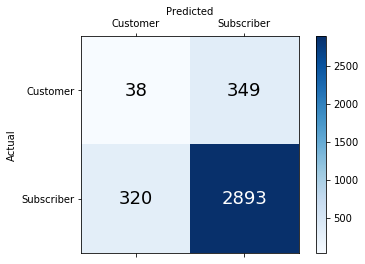

In [110]:
plot_confusion_matrix(cm,classes)

In [111]:
confusion = confusion_matrix(y_test2, y_predicted_class)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

In [112]:
#Accuracy
print((TP + TN) / float(TP + TN + FP + FN))

0.8141666666666667


In [113]:
#Precision
print(TP/float(TP+FP))

0.892350400987045


In [116]:
#Recall
print(TP / float(TP + FN))

0.9004046062869592


# Model building

## Create Dummy Variables

In [126]:
pandadummy_data = pd.get_dummies(data, drop_first=True)

Standard Scale Data

In [136]:
pandadummy_data = {pandadummy_data[['tripduration', 'distance', 'age']]}

,tripduration,distance,age
0,311,919,30
1,282,684,30
2,431,1147,42
3,207,1099,31
4,330,684,34
5,430,1618,36
6,226,1509,30
7,1210,3434,32
8,453,1481,37
9,111,588,31


In [138]:
scaler = StandardScaler()
pandadummy_data[['tripduration','distance','age']] = scaler.fit_transform(pandadummy_data[['tripduration', 'distance', 'age']])

In [139]:
pandadummy_data.head()

,tripduration,distance,age,start_station_name_Astor Place,start_station_name_Baldwin at Montgomery,start_station_name_Bergen Ave,start_station_name_Brunswick & 6th,start_station_name_Brunswick St,start_station_name_Christ Hospital,start_station_name_City Hall,...,gender_Unknown,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday,time_of_day_Morning,time_of_day_Night,usertype_Subscriber
0,-0.042406,-0.480933,-0.748724,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
1,-0.044987,-0.759033,-0.748724,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
2,-0.031728,-0.211117,0.441216,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,-0.051661,-0.267920,-0.649562,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1
4,-0.040716,-0.759033,-0.352077,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,1


In [140]:
X1 = pandadummy_data.drop('usertype_Subscriber',axis=1) 
y1 = pandadummy_data['usertype_Subscriber']


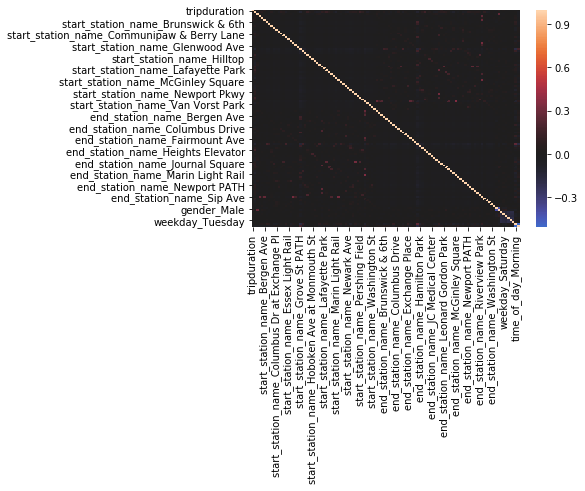

In [141]:
sns.heatmap(X1.corr(),center=0);

## Create train test split 

In [1176]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

## Dummy Estimator

Baseline model to work again.

Before feature engineering

In [348]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [349]:
dummy_class = DummyClassifier()
dummy_class.fit(X_train, y_train)
y_dummy_prediction_ = dummy_class.predict(X_test)
dummy_class.score(X_test, y_test)


0.8047006155567991

In [350]:
print(f'The dummy accuracy is {accuracy_score(y_test, y_dummy_prediction_) * 100}')
print(f'The precision is {precision_score(y_test, y_dummy_prediction_) * 100}')
print(f'The recall is {recall_score(y_test, y_dummy_prediction_)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_dummy_prediction_)*recall_score(y_test, y_dummy_prediction_))/(precision_score(y_test, y_dummy_prediction_)+recall_score(y_test, y_dummy_prediction_))}')

The dummy accuracy is 80.02238388360381
The precision is 88.26291079812206
The recall is 89.2687559354226
The F1 is 0.8876298394711993


In [351]:
print(confusion_matrix(y_test, y_bestforest_prediction))
cm = confusion_matrix(y_test,y_bestforest_prediction)
classes = ['Customer','Subscriber']

[[  52  363]
 [ 360 2799]]


In [352]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

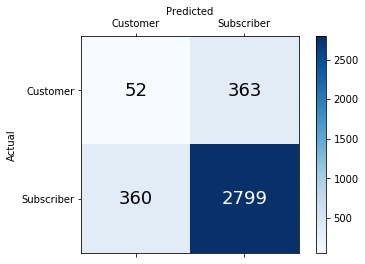

In [353]:
plot_confusion_matrix(cm,classes)

## Dummy Estimator SMOG Optimized

In [354]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    16114
0     1886
Name: usertype_Subscriber, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    12831
0    12831
Name: usertype_Subscriber, dtype: int64


In [355]:
dummy_class = DummyClassifier()
dummy_class.fit(X_train_resampled, y_train_resampled)
y_dummy_prediction_ = dummy_class.predict(X_test)
dummy_class.score(X_test, y_test)

//anaconda3/lib/python3.7/site-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.4986010072747622

In [356]:
print(f'The dummy accuracy is {accuracy_score(y_test, y_dummy_prediction_) * 100}')
print(f'The precision is {precision_score(y_test, y_dummy_prediction_) * 100}')
print(f'The recall is {recall_score(y_test, y_dummy_prediction_)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_dummy_prediction_)*recall_score(y_test, y_dummy_prediction_))/(precision_score(y_test, y_dummy_prediction_)+recall_score(y_test, y_dummy_prediction_))}')

The dummy accuracy is 50.44767767207611
The precision is 88.72767857142857
The recall is 50.332383665716996
The F1 is 0.6422944859624318


In [357]:
print(confusion_matrix(y_test, y_dummy_prediction_))
cm = confusion_matrix(y_test,y_dummy_prediction_)
classes = ['Customer','Subscriber']

[[ 213  202]
 [1569 1590]]


In [358]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

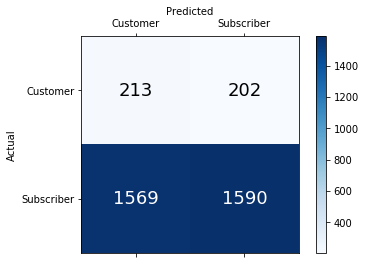

In [359]:
plot_confusion_matrix(cm,classes)

## Create basic decision tree

In [1232]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [1233]:
decision_tree = tree.DecisionTreeClassifier(criterion='entropy', random_state=SEED, max_depth=37)
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=37,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

In [1234]:
y_single_tree_pred = dt.predict(X_test)

In [1231]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_single_tree_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.5161523587226399

In [1239]:
print(f'The basic tree accuracy is {accuracy_score(y_test, y_single_tree_pred) * 100}')
print(f'The precision is {precision_score(y_test, y_single_tree_pred) * 100}')
print(f'The recall is {recall_score(y_test, y_single_tree_pred)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_single_tree_pred)*recall_score(y_test, y_single_tree_pred))/(precision_score(y_test, y_single_tree_pred)+recall_score(y_test, y_single_tree_pred))}')


The basic tree accuracy is 81.2534974818131
The precision is 88.75739644970415
The recall is 90.21842355175689
The F1 is 0.8948194662480378


My vanilla tree is very bad, it cant correctly make a classification.

## Random Forest

In [213]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [214]:
forest = RandomForestClassifier(n_estimators=200, max_depth=6, random_state=SEED)

In [215]:
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [216]:
print(f'This training set is {forest.score(X_train, y_train)*100} % accurate')

This training set is 89.76493633692458 % accurate


In [217]:
print(f'This testing set is {forest.score(X_test, y_test)*100} % accurate')

This testing set is 88.38836038052602 % accurate


In [218]:
y_forest_prediction = forest.predict(X_test)

In [219]:
print(f'The random forest accuracy is {accuracy_score(y_test, y_forest_prediction) * 100}')
print(f'The precision is {precision_score(y_test, y_forest_prediction) * 100}')
print(f'The recall is {recall_score(y_test, y_forest_prediction)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_forest_prediction)*recall_score(y_test, y_forest_prediction))/(precision_score(y_test, y_forest_prediction)+recall_score(y_test, y_forest_prediction))}')


The random forest accuracy is 88.38836038052602
The precision is 88.38836038052602
The recall is 100.0
The F1 is 0.938363285311154


## Feature importance

In [220]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,20))
    plt.barh(range(n_features), model.feature_importances_) 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

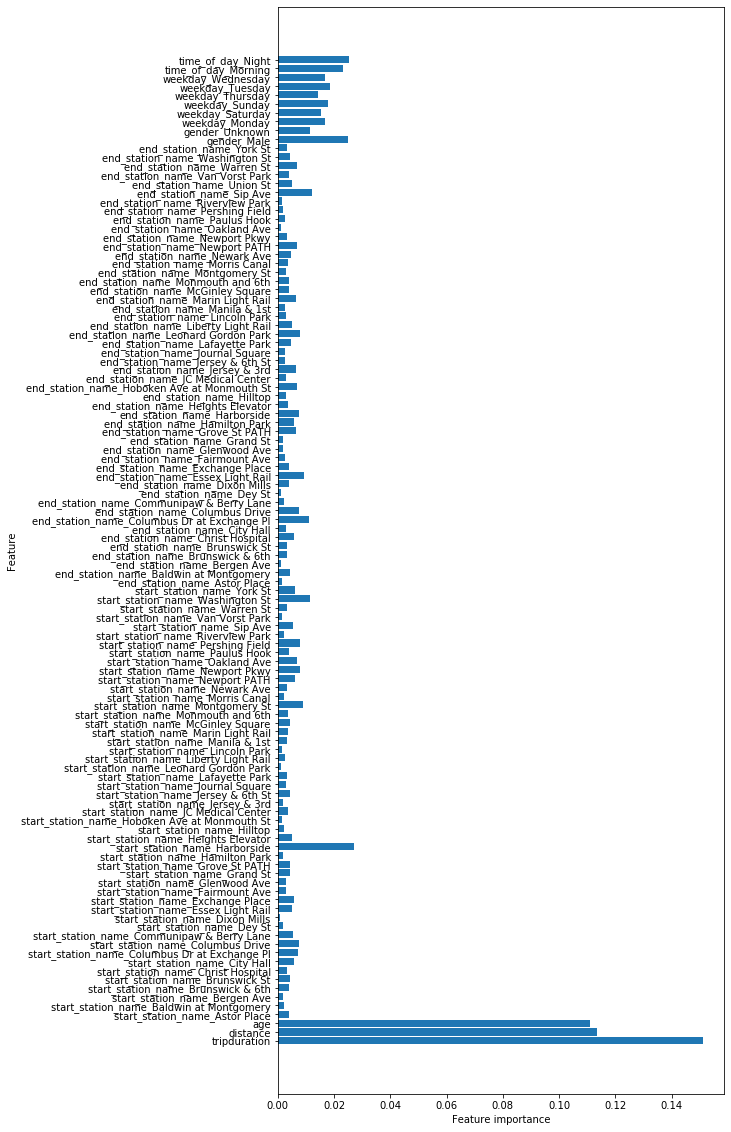

In [221]:
plot_feature_importances(forest)

## Random Forest Grid Search

## Grid Search Random Forest

In [ ]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [973]:
random_forest = RandomForestClassifier()


Base case

In [974]:
mean_auto_forest_score = np.mean(cross_val_score(random_forest, X_train, y_train, cv =4))

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [975]:
mean_auto_forest_score

0.8746328623234496

With GridSearch

In [327]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)
random_forest = RandomForestClassifier()

In [328]:
forest_param_grid = {
    'n_estimators': [30,40,50],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 1],
    'min_samples_split': [4,5,6],
    'min_samples_leaf' : [1,2,3,4]
}

In [329]:
grid_search_forest = GridSearchCV(random_forest, forest_param_grid, cv=3)
grid_search_forest.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [330]:
print(grid_search_forest.best_score_)
print(grid_search_forest.best_params_)

0.8976493868406191
{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 40}


## SMOT Grid Search Forest

In [331]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    16114
0     1886
Name: usertype_Subscriber, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    12831
0    12831
Name: usertype_Subscriber, dtype: int64


In [332]:
grid_search_forest = GridSearchCV(random_forest, forest_param_grid, cv=3)
grid_search_forest.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [333]:
print(grid_search_forest.best_score_)
print(grid_search_forest.best_params_)

0.8795495284856987
{'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 50}


## Optimized SMOT Forest

In [334]:
bestforest = RandomForestClassifier(criterion= 'entropy', max_depth=None, min_samples_leaf=1, min_samples_split=6, n_estimators=50,  random_state=SEED)
bestforest.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=6,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [336]:
print(f'this model is {bestforest.score(X_train_resampled,y_train_resampled) * 100} % accurate')
print(f'this model is {bestforest.score(X_test,y_test)*100} % accurate')

this model is 98.23864079183228 % accurate
this model is 79.77056519306099 % accurate


In [337]:
y_bestforest_prediction = bestforest.predict(X_test)

In [338]:
print(f'The random forest accuracy is {accuracy_score(y_test, y_bestforest_prediction) * 100}')
print(f'The precision is {precision_score(y_test, y_bestforest_prediction) * 100}')
print(f'The recall is {recall_score(y_test, y_bestforest_prediction)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_bestforest_prediction)*recall_score(y_test, y_bestforest_prediction))/(precision_score(y_test, y_bestforest_prediction)+recall_score(y_test, y_bestforest_prediction))}')


The random forest accuracy is 79.77056519306099
The precision is 88.51992409867174
The recall is 88.6039886039886
The F1 is 0.8856193640246797


In [339]:
print(confusion_matrix(y_test, y_bestforest_prediction))
cm = confusion_matrix(y_test,y_bestforest_prediction)
classes = ['Customer','Subscriber']

[[  52  363]
 [ 360 2799]]


In [340]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

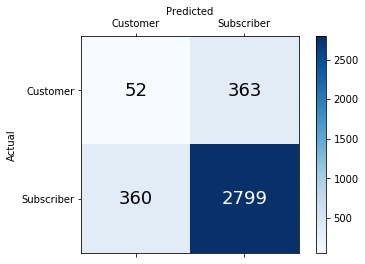

In [341]:
plot_confusion_matrix(cm,classes)

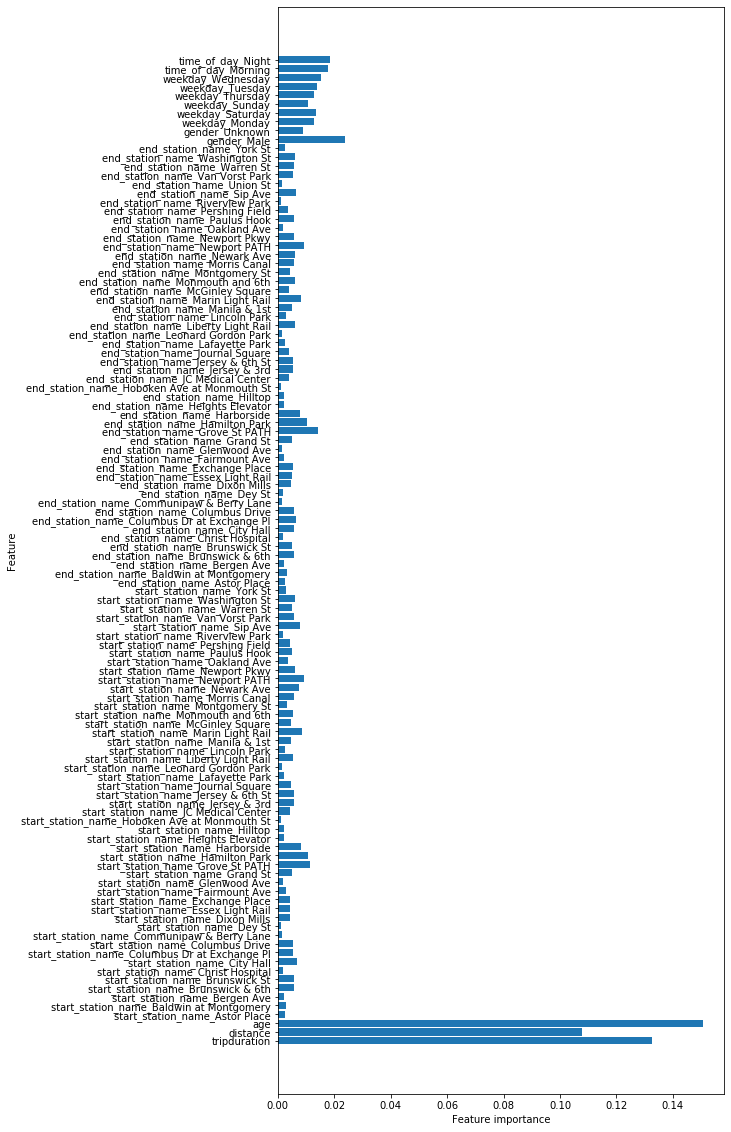

In [342]:
plot_feature_importances(bestforest)

## Optimized Forest

In [202]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [203]:
bestforest = RandomForestClassifier(criterion= 'gini', max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=40,  random_state=SEED)
bestforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [204]:
print(f'this model is {bestforest.score(X_train,y_train) * 100} % accurate')
print(f'this model is {bestforest.score(X_test,y_test)*100} % accurate')

this model is 89.77193227927802 % accurate
this model is 88.38836038052602 % accurate


In [205]:
y_bestforest_prediction = bestforest.predict(X_test)

In [206]:
print(f'The random forest accuracy is {accuracy_score(y_test, y_bestforest_prediction) * 100}')
print(f'The precision is {precision_score(y_test, y_bestforest_prediction) * 100}')
print(f'The recall is {recall_score(y_test, y_bestforest_prediction)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_bestforest_prediction)*recall_score(y_test, y_bestforest_prediction))/(precision_score(y_test, y_bestforest_prediction)+recall_score(y_test, y_bestforest_prediction))}')


The random forest accuracy is 88.38836038052602
The precision is 88.38836038052602
The recall is 100.0
The F1 is 0.938363285311154


In [207]:
print(confusion_matrix(y_test, y_bestforest_prediction))
cm = confusion_matrix(y_test,y_bestforest_prediction)
classes = ['Customer','Subscriber']

[[   0  415]
 [   0 3159]]


In [208]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

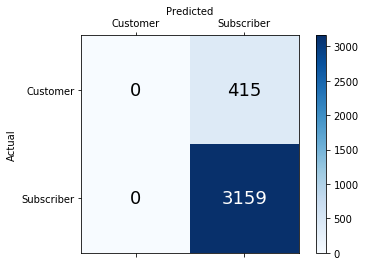

In [209]:
plot_confusion_matrix(cm,classes)

Because the best max_depth is None each tree has a maximim depth. All of the nodes are expanded until the leavees are pure or all contain less than the min_samples_split which is 5. 

## XGBoost

In [225]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [226]:
XGbooster = XGBClassifier(learning_rate = 0.15,
                         max_depth = 3,
                         min_child_weight = 1,
                         n_estimators = 120,
                         subsample = .6)
XGbooster.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [227]:
#predictions on training set
y_XGtrain_predictions = XGbooster.predict(X_train)
y_XGtest_predictions = XGbooster.predict(X_test)

In [228]:
training_accuracy = accuracy_score(y_train, y_XGtrain_predictions)
test_accuracy = accuracy_score(y_test, y_XGtest_predictions)

print(f'training accuracy is {training_accuracy*100}')
print(f'validation accuracy is {test_accuracy*100}')

training accuracy is 89.79292010633833
validation accuracy is 88.38836038052602


In [229]:
# print(f'The random forest accuracy is {accuracy_score(y_test, y_bestforest_prediction) * 100}')
# print(f'The precision is {precision_score(y_test, y_bestforest_prediction) * 100}')
# print(f'The recall is {recall_score(y_test, y_bestforest_prediction)*100}')
# print(f'The F1 is {2*(precision_score(y_test, y_bestforest_prediction)*recall_score(y_test, y_bestforest_prediction))/(precision_score(y_test, y_bestforest_prediction)+recall_score(y_test, y_bestforest_prediction))}')

print(f'The XGBoost accuracy is {accuracy_score(y_test, y_XGtest_predictions) * 100}')
print(f'The precision is {precision_score(y_test, y_XGtest_predictions) * 100}')
print(f'The recall is {recall_score(y_test, y_XGtest_predictions)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_XGtest_predictions)*recall_score(y_test, y_XGtest_predictions))/(precision_score(y_test, y_XGtest_predictions)+recall_score(y_test, y_XGtest_predictions))}')

The XGBoost accuracy is 88.38836038052602
The precision is 88.38836038052602
The recall is 100.0
The F1 is 0.938363285311154


In [230]:
print(confusion_matrix(y_test, y_XGtest_predictions))
cm = confusion_matrix(y_test,y_XGtest_predictions)
classes = ['Customer','Subscriber']

[[   0  415]
 [   0 3159]]


In [231]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

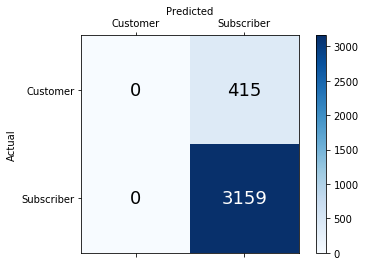

In [232]:
plot_confusion_matrix(cm,classes)

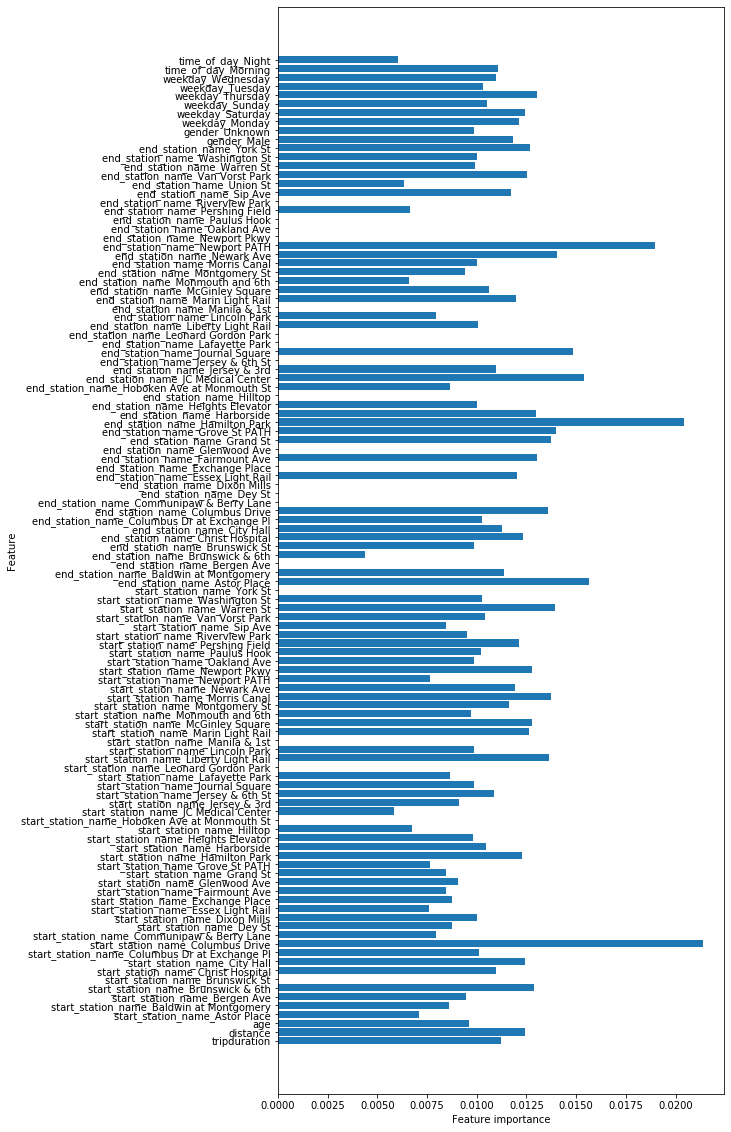

In [989]:
plot_feature_importances(XGbooster)

## Optimized XG Boosted Values

In [308]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [309]:
XGbooster = XGBClassifier(learning_rate = 0.15,
                         max_depth = 4,
                         min_child_weight = 1,
                         n_estimators = 120,
                         subsample = .6)
XGbooster.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [310]:
#predictions on training set
y_XGtrain_predictions = XGbooster.predict(X_train)
y_XGtest_predictions = XGbooster.predict(X_test)

In [311]:
training_accuracy = accuracy_score(y_train, y_XGtrain_predictions)
test_accuracy = accuracy_score(y_test, y_XGtest_predictions)

print(f'training accuracy is {training_accuracy*100}')
print(f'validation accuracy is {test_accuracy*100}')

training accuracy is 89.83489576045893
validation accuracy is 88.30442081701176


In [312]:
print(f'The XGBoost accuracy is {accuracy_score(y_test, y_XGtest_predictions) * 100}')
print(f'The precision is {precision_score(y_test, y_XGtest_predictions) * 100}')
print(f'The recall is {recall_score(y_test, y_XGtest_predictions)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_XGtest_predictions)*recall_score(y_test, y_XGtest_predictions))/(precision_score(y_test, y_XGtest_predictions)+recall_score(y_test, y_XGtest_predictions))}')

The XGBoost accuracy is 88.30442081701176
The precision is 88.37860543265191
The recall is 99.90503323836657
The F1 is 0.9378900445765229


In [313]:
print(confusion_matrix(y_test, y_XGtest_predictions))
cm = confusion_matrix(y_test,y_XGtest_predictions)
classes = ['Customer','Subscriber']

[[   0  415]
 [   3 3156]]


In [314]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

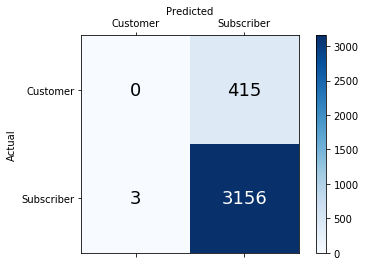

In [315]:
plot_confusion_matrix(cm,classes)

## Optimized SMOTE XG Boosted Values

In [316]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    16114
0     1886
Name: usertype_Subscriber, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    12831
0    12831
Name: usertype_Subscriber, dtype: int64


In [317]:
XGbooster = XGBClassifier(learning_rate = 0.15,
                         max_depth = 4,
                         min_child_weight = 1,
                         n_estimators = 120,
                         subsample = .6)
XGbooster.fit(X_train_resampled,y_train_resampled)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=120, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [318]:
#predictions on training set
y_XGtrain_predictions = XGbooster.predict(X_train_resampled)
y_XGtest_predictions = XGbooster.predict(X_test)

In [319]:
training_accuracy = accuracy_score(y_train_resampled, y_XGtrain_predictions)
test_accuracy = accuracy_score(y_test, y_XGtest_predictions)

print(f'training accuracy is {training_accuracy*100}')
print(f'validation accuracy is {test_accuracy*100}')

training accuracy is 87.19507442911699
validation accuracy is 77.72803581421377


In [320]:
print(f'The XGBoost accuracy is {accuracy_score(y_test, y_XGtest_predictions) * 100}')
print(f'The precision is {precision_score(y_test, y_XGtest_predictions) * 100}')
print(f'The recall is {recall_score(y_test, y_XGtest_predictions)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_XGtest_predictions)*recall_score(y_test, y_XGtest_predictions))/(precision_score(y_test, y_XGtest_predictions)+recall_score(y_test, y_XGtest_predictions))}')

The XGBoost accuracy is 77.72803581421377
The precision is 88.49788204626914
The recall is 85.97657486546375
The F1 is 0.8721901091843288


In [321]:
print(confusion_matrix(y_test, y_XGtest_predictions))
cm = confusion_matrix(y_test,y_XGtest_predictions)
classes = ['Customer','Subscriber']

[[  62  353]
 [ 443 2716]]


In [322]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

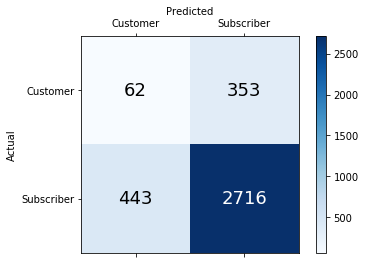

In [323]:
plot_confusion_matrix(cm,classes)

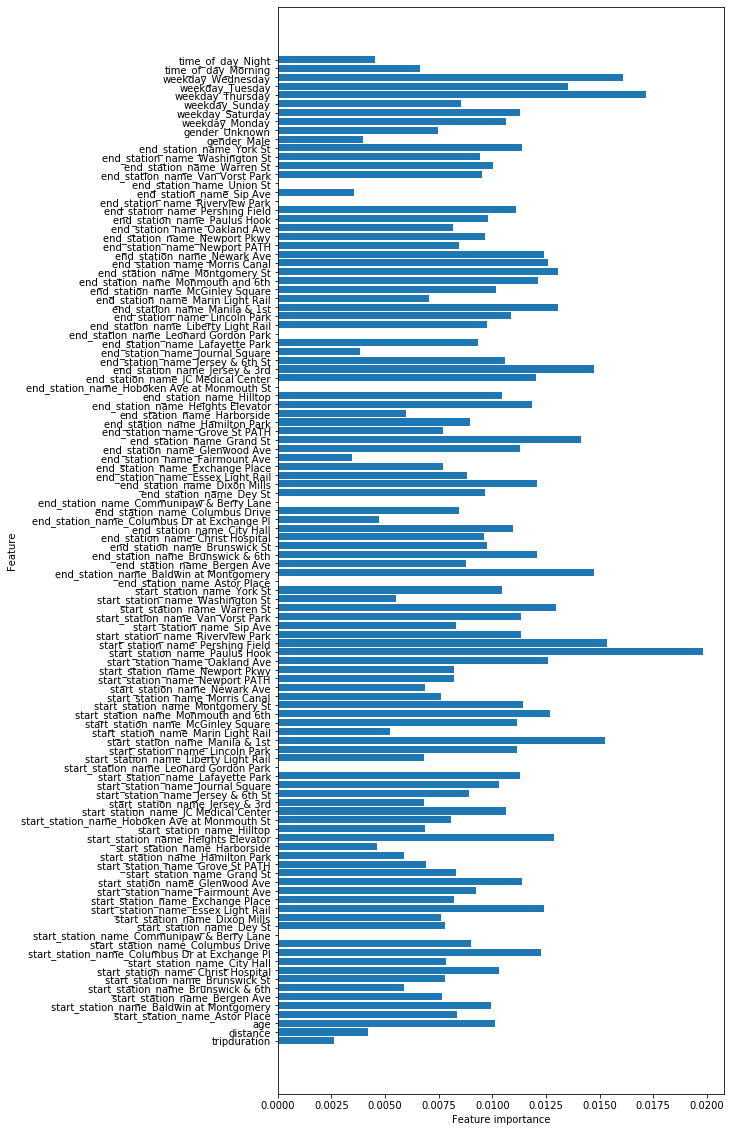

In [343]:
plot_feature_importances(XGbooster)

## XGBoost with Gridsearch

In [300]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [301]:
boosting_parameters = {
    'learning_rate':[0.05,0.1,0.15],
    'max_depth':[1,2,3,4],
    'min_child_weight':[1,2,3],
    'subsample':[0.6,0.7,0.8],
    'n_estimators':[80,100, 120]
}

In [302]:
#predictions on training set
training_predictions = XGbooster.predict(X_train)
test_predications = XGbooster.predict(X_test)

In [303]:
gridsearch_XG = GridSearchCV(XGbooster, boosting_parameters, cv=2, n_jobs=1)
gridsearch_XG.fit(X_train, y_train)

best_parameters = gridsearch_XG.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = gridsearch_XG.predict(X_train)
test_preds = gridsearch_XG.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 3
min_child_weight: 1
n_estimators: 120
subsample: 0.7

Training Accuracy: 89.78%
Validation accuracy: 88.36%


## SMOTE XG Boosted Grid Search Values

In [304]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    16114
0     1886
Name: usertype_Subscriber, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    12831
0    12831
Name: usertype_Subscriber, dtype: int64


In [305]:
gridsearch_XG = GridSearchCV(XGbooster, boosting_parameters, cv=2, n_jobs=1)
gridsearch_XG.fit(X_train_resampled, y_train_resampled)

best_parameters = gridsearch_XG.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))


Grid Search found the following optimal parameters: 
learning_rate: 0.15
max_depth: 4
min_child_weight: 1
n_estimators: 120
subsample: 0.6


NameError: name 'X_test_resampled' is not defined

In [306]:
training_preds = gridsearch_XG.predict(X_train_resampled)
test_preds = gridsearch_XG.predict(X_test)
training_accuracy = accuracy_score(y_train_resampled, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))


Training Accuracy: 86.63%
Validation accuracy: 76.89%


In [307]:
print(f'The XGBoost accuracy is {accuracy_score(y_test, test_preds) * 100}')
print(f'The precision is {precision_score(y_test, test_preds) * 100}')
print(f'The recall is {recall_score(y_test, test_preds)*100}')
print(f'The F1 is {2*(precision_score(y_test, test_preds)*recall_score(y_test, test_preds))/(precision_score(y_test, test_preds)+recall_score(y_test, test_preds))}')

The XGBoost accuracy is 76.88864017907106
The precision is 88.56198347107438
The recall is 84.80531813865147
The F1 is 0.8664294954721863


# Logistic Regression

In [378]:
SEED=1
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=.2, random_state = SEED)

In [379]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [380]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train)

In [381]:
residuals = np.abs(y_train - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0      12831
255     1463
Name: usertype_Subscriber, dtype: int64
0      0.897649
255    0.102351
Name: usertype_Subscriber, dtype: float64


In [382]:
log_train_score = logreg.score(X_train,y_train)
print(f'This model is {log_train_score * 100} % accurate')

This model is 89.76493633692458 % accurate


In [383]:
residuals = np.abs(y_test - y_hat_test)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0      3159
255     415
Name: usertype_Subscriber, dtype: int64
0      0.883884
255    0.116116
Name: usertype_Subscriber, dtype: float64


In [384]:
log_test_score = logreg.score(X_test,y_test)
print(f'This model is {log_test_score * 100} % accurate')

This model is 88.38836038052602 % accurate


In [385]:
print(f'The logistic regression accuracy is {accuracy_score(y_test, y_hat_test) * 100}')
print(f'The precision is {precision_score(y_test, y_hat_test) * 100}')
print(f'The recall is {recall_score(y_test, y_hat_test)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_hat_test)*recall_score(y_test, y_hat_test))/(precision_score(y_test, y_hat_test)+recall_score(y_test, y_hat_test))}')

The logistic regression accuracy is 88.38836038052602
The precision is 88.38836038052602
The recall is 100.0
The F1 is 0.938363285311154


In [386]:
print(confusion_matrix(y_test, y_hat_test))
cm = confusion_matrix(y_test,y_hat_test)
classes = ['Customer','Subscriber']

[[   0  415]
 [   0 3159]]


In [387]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

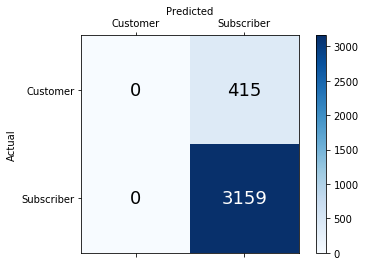

In [388]:
plot_confusion_matrix(cm,classes)

## SMOTE Log Reg

In [389]:
from imblearn.over_sampling import SMOTE

In [390]:
# Previous original class distribution
print('Original class distribution: \n')
print(y.value_counts())
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train) 
# Preview synthetic sample class distribution
print('-----------------------------------------')
print('Synthetic sample class distribution: \n')
print(pd.Series(y_train_resampled).value_counts()) 

Original class distribution: 

1    16114
0     1886
Name: usertype_Subscriber, dtype: int64
-----------------------------------------
Synthetic sample class distribution: 

1    12831
0    12831
Name: usertype_Subscriber, dtype: int64


In [391]:
logreg.fit(X_train_resampled, y_train_resampled)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [392]:
y_hat_test = logreg.predict(X_test)
y_hat_train = logreg.predict(X_train_resampled)

In [393]:
residuals = np.abs(y_train_resampled - y_hat_train)
print(pd.Series(residuals).value_counts())
print(pd.Series(residuals).value_counts(normalize=True))

0      21816
255     2422
1       1424
Name: usertype_Subscriber, dtype: int64
0      0.850129
255    0.094381
1      0.055491
Name: usertype_Subscriber, dtype: float64


In [394]:
log_test_score = logreg.score(X_test,y_test)
print(f'This model is {log_test_score * 100} % accurate')

This model is 80.88975937325125 % accurate


In [395]:
print(f'The logistic regression accuracy is {accuracy_score(y_test, y_hat_test) * 100}')
print(f'The precision is {precision_score(y_test, y_hat_test) * 100}')
print(f'The recall is {recall_score(y_test, y_hat_test)*100}')
print(f'The F1 is {2*(precision_score(y_test, y_hat_test)*recall_score(y_test, y_hat_test))/(precision_score(y_test, y_hat_test)+recall_score(y_test, y_hat_test))}')

The logistic regression accuracy is 80.88975937325125
The precision is 88.6633354153654
The recall is 89.87021209243431
The F1 is 0.8926269454488287


In [396]:
print(confusion_matrix(y_test, y_hat_test))
cm = confusion_matrix(y_test,y_hat_test)
classes = ['Customer','Subscriber']

[[  52  363]
 [ 320 2839]]


In [397]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

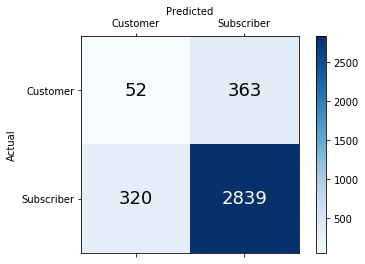

In [398]:
plot_confusion_matrix(cm,classes)

In [399]:
logreg.coef_

array([[-0.02086084,  0.25713778,  0.11018033,  3.17866868,  3.48853572,
         3.47716432,  3.22964275,  3.50272105,  3.77419644,  3.35171977,
         4.27996651,  3.56372045,  3.04267018,  3.5072587 ,  3.7107985 ,
         4.19230282,  3.19554357,  3.1121321 ,  4.18886865,  3.50791483,
         3.03108201,  2.95966361,  2.81320436,  4.28892846,  3.87291641,
         3.49987107,  3.63901738,  3.21395573,  3.54577065,  3.67703971,
         3.94403078,  3.02865485,  2.89233368,  4.05065837,  3.6943422 ,
         3.2219459 ,  3.75308061,  3.7799588 ,  3.27238652,  3.42002308,
         3.56911596,  3.36892422,  3.15241661,  4.56181697,  4.03628302,
         4.54244319,  4.11446113,  3.24609201,  3.56940258,  3.66753446,
         3.11198744,  3.77197228,  2.73991637,  4.53826518,  3.33288255,
         3.33023122,  3.56532643,  3.72765042,  3.80225977,  2.92569693,
         3.79444576,  3.1367804 ,  4.07022147,  3.53104664,  3.20469986,
         3.48740308,  2.90752408,  3.99378743,  4.1

In [400]:
y_pred_prob = logreg.predict_proba(X_test)[:, 1]

In [401]:
y_pred_prob[:10]

array([0.9211083 , 0.77608048, 0.55974681, 0.81390139, 0.78050942,
       0.71234284, 0.93461439, 0.93938078, 0.85650384, 0.56034712])

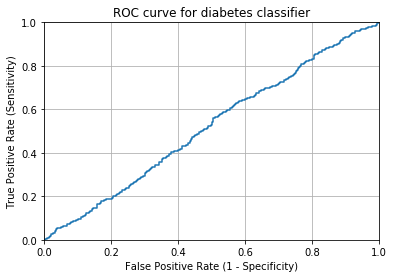

In [403]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [373]:
dictionary = dict(zip(list(X_train_resampled.columns), list(logreg.coef_[0])))
print('Logistic Regression Model:')
print('--'*27)
print(f'Intercept: {logreg.intercept_[0] : 0.3}\n')
print(f'Coefficients: ')
coefficients = list(dictionary.values())
for i, coefficient in enumerate(dictionary):
    print(f'  {coefficient} = {list(dictionary.values())[i] : 0.3}')

Logistic Regression Model:
------------------------------------------------------
Intercept: -7.57

Coefficients: 
  tripduration = -0.023
  distance =  0.272
  age =  0.111
  start_station_name_Astor Place =  3.4
  start_station_name_Baldwin at Montgomery =  3.34
  start_station_name_Bergen Ave =  3.54
  start_station_name_Brunswick & 6th =  3.41
  start_station_name_Brunswick St =  3.53
  start_station_name_Christ Hospital =  3.79
  start_station_name_City Hall =  3.36
  start_station_name_Columbus Dr at Exchange Pl =  4.26
  start_station_name_Columbus Drive =  3.68
  start_station_name_Communipaw & Berry Lane =  2.85
  start_station_name_Dey St =  3.75
  start_station_name_Dixon Mills =  3.81
  start_station_name_Essex Light Rail =  4.22
  start_station_name_Exchange Place =  3.27
  start_station_name_Fairmount Ave =  3.18
  start_station_name_Glenwood Ave =  4.22
  start_station_name_Grand St =  3.62
  start_station_name_Grove St PATH =  3.14
  start_station_name_Hamilton Park =  

### Logistic regression confusion matrix

In [295]:
print(confusion_matrix(y_test, y_hat_test))
cm = confusion_matrix(y_test,y_hat_test)
classes = ['Customer','Subscriber']

[[  55  360]
 [ 320 2839]]


In [296]:
def plot_confusion_matrix(cm, classes):
    cmap = plt.cm.Blues
    fig = plt.figure();
    ax = fig.add_subplot(111);
    cax = ax.matshow(cm, cmap=cmap);
    fig.colorbar(cax);
    ax.set_xticklabels([''] + classes);
    ax.set_yticklabels([''] + classes);
    ax.xaxis.set_label_position('top');
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'), {
            'fontsize' : 18,
            'horizontalalignment' : "center",
            'verticalalignment' : "center"
        }, color="white" if cm[i, j] > thresh else "black")
    plt.xlabel('Predicted');
    plt.ylabel('Actual') ;
    plt.show();

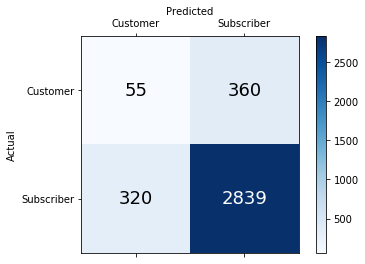

In [297]:
plot_confusion_matrix(cm,classes)